<a href="https://colab.research.google.com/github/SalhaAlzahrani/KD_TripartiteAtten/blob/main/Ablation1__ClassW_KonwledgeDistillation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟢  Ablation Study 1: Class Weighting

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv tensorflow --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

## Hyperparameters

In [ ]:
IMG_SIZE = 224 # We'll resize input images to this size.
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
dropout_rate = 0.2

In [ ]:
def plot_training_curves(history, title, model_name=''):
    if (model_name == 'teacher'):
      loss = np.array(history.history['loss'])
      val_loss = np.array(history.history['val_loss'])
      epochs = range(len(history.history['loss']))
    else:
      loss = np.array(history.history['student_loss'])
      val_loss = np.array(history.history['val_student_loss'])
      epochs = range(len(history.history['student_loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('fivethirtyeight')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend()

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='bone')
      ax.grid()
      plt.axis("off")

# Construct Distiller() class





In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#run_experiment module

In [ ]:
from keras.src.callbacks import LearningRateScheduler
def run_experiment(training_dataset, validation_dataset, model, model_name='', weighting = False):
    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compile the model.
    if(model_name == 'teacher'):
      model.compile(
          optimizer=optimizer,
          loss=keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", patience=15, restore_best_weights=True
      )
    else:
      distiller.compile(
          optimizer=keras.optimizers.Adam(),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
          student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
          distillation_loss_fn=keras.losses.KLDivergence(),
          alpha=0.1,
          temperature=10,
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="student_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="student_loss", patience=15, restore_best_weights=True
      )
    if weighting:
      # Fit the model with class_weights_dict
      history = model.fit(
          training_dataset,
          validation_data = validation_dataset,
          batch_size=batch_size,
          epochs=num_epochs,
          class_weight=class_weights_dict,
          callbacks=[early_stopping, reduce_lr],
      )
    else:
      # Fit the modelwith no class weighting
      history = model.fit(
          training_dataset,
          validation_data = validation_dataset,
          batch_size=batch_size,
          epochs=num_epochs,
          callbacks=[early_stopping, reduce_lr],
      )
    # Return history to plot learning curves.
    return history

# 📂 Load BTDS-15C

In [ ]:
##################
NUM_CLASSES = 15
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_15Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4455 files belonging to 15 classes.
Using 3564 files for training.
Found 4455 files belonging to 15 classes.
Using 891 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4455 files belonging to 15 classes.


{0: 0.512183908045977,
 1: 1.1835325365205844,
 2: 1.9804444444444445,
 3: 7.817543859649123,
 4: 2.970666666666667,
 5: 1.4562091503267973,
 6: 3.8085470085470083,
 7: 2.267684478371501,
 8: 0.3398932112890923,
 9: 0.650036469730124,
 10: 0.5690932311621967,
 11: 1.3261904761904761,
 12: 1.2534458509142052,
 13: 0.6388530465949821,
 14: 2.048735632183908}

## ◼ No Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 292s 2s/step - loss: 950.9208 - accuracy: 0.3634 - top5-acc: 0.6818 - Brier score: 5369143.0000 - auc: 0.6552 - val_loss: 32.6171 - val_accuracy: 0.6970 - val_top5-acc: 0.9327 - val_Brier score: 37758.0430 - val_auc: 0.7639 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 40ms/step - loss: 22.2515 - accuracy: 0.7646 - top5-acc: 0.9675 - Brier score: 56203.9102 - auc: 0.7763 - val_loss: 32.2279 - val_accuracy: 0.7172 - val_top5-acc: 0.9360 - val_Brier score: 53158.5586 - val_auc: 0.7499 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 40ms/step - loss: 6.2186 - accuracy: 0.8895 - top5-acc: 0.9944 - Brier score: 50784.4180 - auc: 0.7962 - val_loss: 20.4539 - val_accuracy: 0.8159 - val_top5-acc: 0.9742 - val_Brier score: 51486.0820 - val_auc: 0.7962 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 5s 39ms/step - loss: 2.5305 - accuracy: 0.9408 - top5-acc: 0.9978 - Brier sc

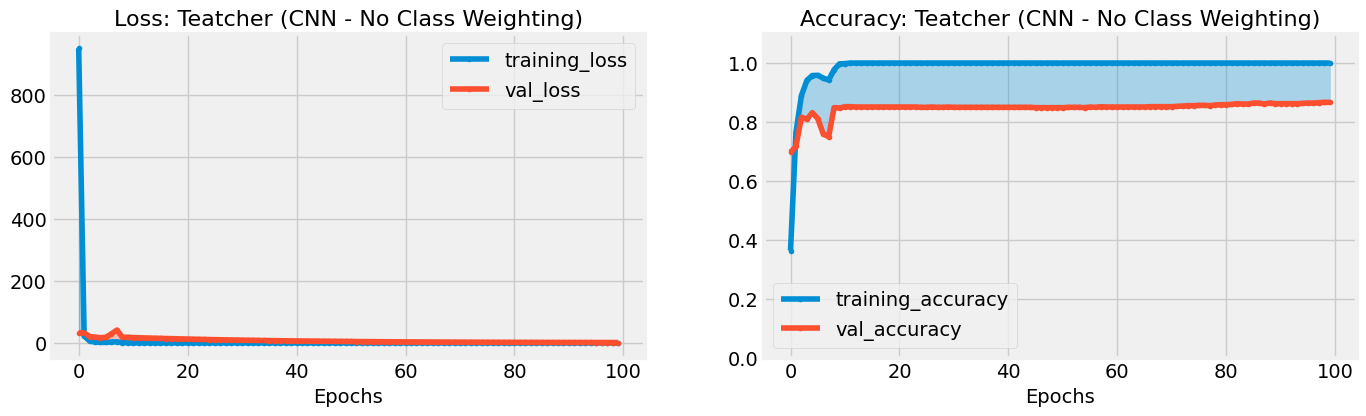

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 6s 29ms/step - accuracy: 0.2879 - top5-acc: 0.6033 - Brier score: 74799.6953 - auc: 0.6199 - student_loss: 202.7955 - distillation_loss: 794.3218 - val_accuracy: 0.3535 - val_top5-acc: 0.6835 - val_Brier score: 13139.4365 - val_auc: 0.6238 - val_student_loss: 48.5876 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 3s 25ms/step - accuracy: 0.5480 - top5-acc: 0.8479 - Brier score: 3240.1797 - auc: 0.6847 - student_loss: 14.5333 - distillation_loss: 209.2974 - val_accuracy: 0.5241 - val_top5-acc: 0.8418 - val_Brier score: 1031.9291 - val_auc: 0.6720 - val_student_loss: 8.9736 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 3s 24ms/step - accuracy: 0.6849 - top5-acc: 0.9167 - Brier score: 791.6798 - auc: 0.7019 - student_loss: 4.7076 - distillation_loss: 70.2474 - val_accuracy: 0.5791 - val_top5-acc: 0.8945 - val_Brier score: 356.6826 - val_auc: 0.6989 - val_student_loss: 6.4697 - lr: 0.0010
Epoc

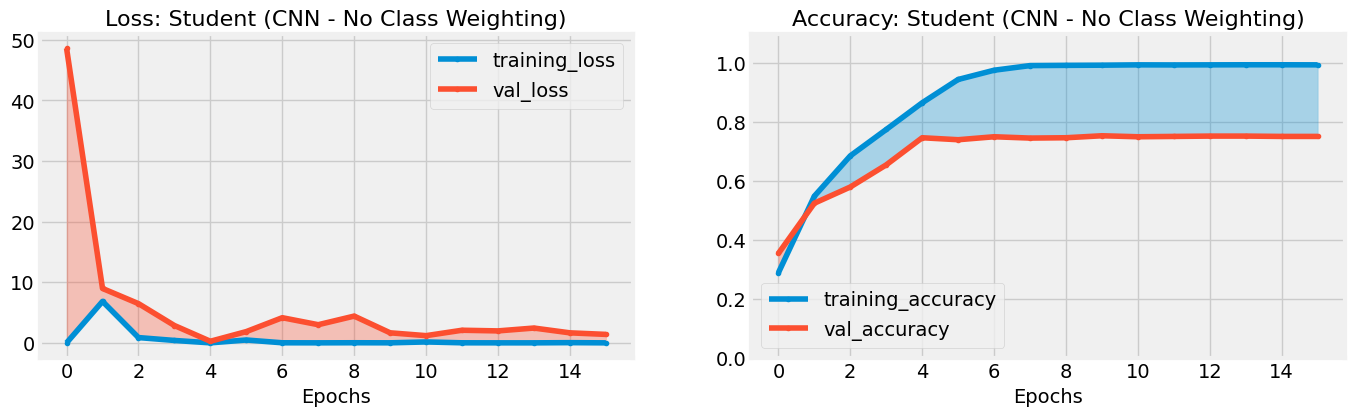

In [ ]:
plot_training_curves(history, 'Student (CNN - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 6s 42ms/step - loss: 314.1727 - accuracy: 0.3883 - top5-acc: 0.7054 - Brier score: 301767.5000 - auc: 0.6464 - val_loss: 28.1923 - val_accuracy: 0.5960 - val_top5-acc: 0.8990 - val_Brier score: 9179.1807 - val_auc: 0.7207 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 39ms/step - loss: 3.2712 - accuracy: 0.8490 - top5-acc: 0.9865 - Brier score: 8673.6699 - auc: 0.7048 - val_loss: 9.0611 - val_accuracy: 0.7834 - val_top5-acc: 0.9585 - val_Brier score: 6787.2378 - val_auc: 0.6856 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 39ms/step - loss: 2.2496 - accuracy: 0.8838 - top5-acc: 0.9933 - Brier score: 10341.8213 - auc: 0.7098 - val_loss: 9.4562 - val_accuracy: 0.7980 - val_top5-acc: 0.9641 - val_Brier score: 7033.0674 - val_auc: 0.7086 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 5s 39ms/step - loss: 1.0422 - accuracy: 0.9270 - top5-acc: 0.9978 - Brier score: 886

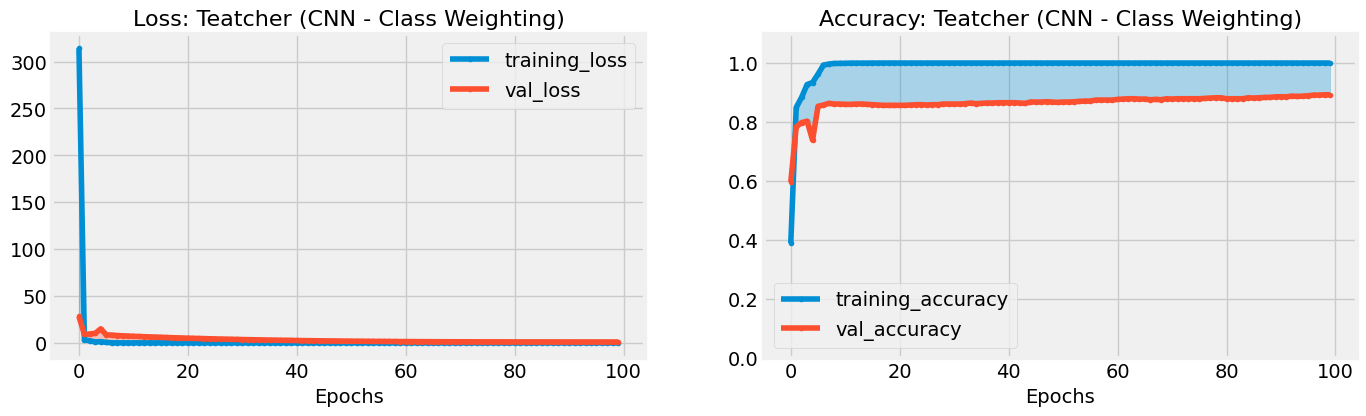

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 5s 27ms/step - accuracy: 0.4860 - top5-acc: 0.8056 - Brier score: 13460.2041 - auc: 0.6077 - student_loss: 31.2787 - distillation_loss: 321.3172 - val_accuracy: 0.4646 - val_top5-acc: 0.8058 - val_Brier score: 1210.4948 - val_auc: 0.5651 - val_student_loss: 8.5802 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 3s 25ms/step - accuracy: 0.6083 - top5-acc: 0.8549 - Brier score: 860.9126 - auc: 0.5810 - student_loss: 7.6997 - distillation_loss: 91.5038 - val_accuracy: 0.5735 - val_top5-acc: 0.8597 - val_Brier score: 335.3385 - val_auc: 0.6199 - val_student_loss: 3.5255 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 3s 24ms/step - accuracy: 0.7579 - top5-acc: 0.9293 - Brier score: 500.8365 - auc: 0.5800 - student_loss: 3.3340 - distillation_loss: 41.9674 - val_accuracy: 0.6846 - val_top5-acc: 0.9428 - val_Brier score: 287.6050 - val_auc: 0.6149 - val_student_loss: 3.2456 - lr: 0.0010
Epoch 4/100

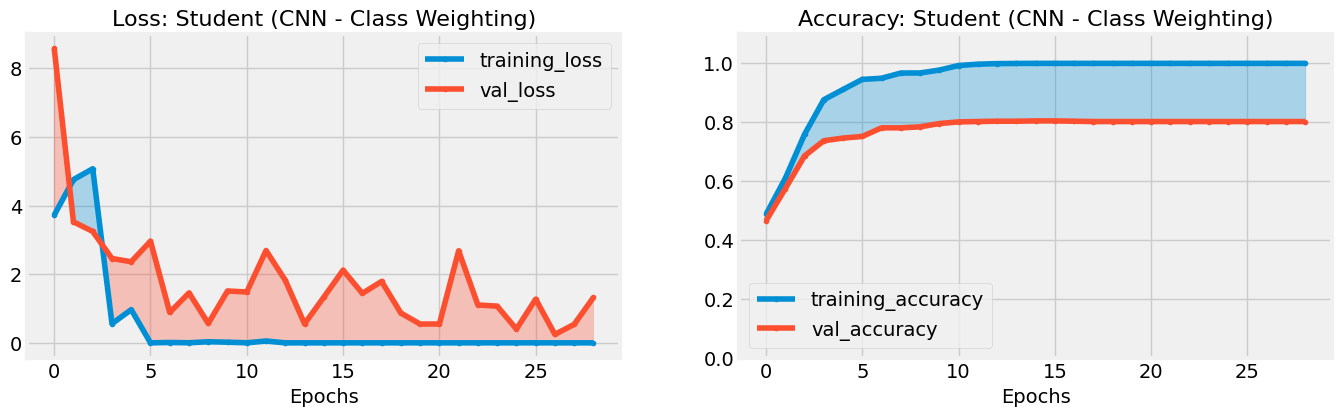

In [ ]:
plot_training_curves(history, 'Student (CNN - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (Multi-head Self-Attention)



In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
#vanilla=True ====> traditional transformer with multi-head self attention
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=True)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=True)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 50s 349ms/step - loss: 16.2043 - accuracy: 0.1437 - top5-acc: 0.5196 - Brier score: 470.8324 - auc: 0.5921 - val_loss: 2.6059 - val_accuracy: 0.1751 - val_top5-acc: 0.6364 - val_Brier score: 0.0789 - val_auc: 0.6756 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 37s 331ms/step - loss: 2.5382 - accuracy: 0.1987 - top5-acc: 0.6484 - Brier score: 0.1423 - auc: 0.6840 - val_loss: 2.4993 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.2080 - val_auc: 0.6778 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 37s 331ms/step - loss: 2.4675 - accuracy: 0.1992 - top5-acc: 0.6504 - Brier score: 0.2841 - auc: 0.6866 - val_loss: 2.4689 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.3678 - val_auc: 0.6778 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 37s 330ms/step - loss: 2.4469 - accuracy: 0.1992 - top5-acc: 0.6526 - Brier score: 0.4232 - auc: 0.

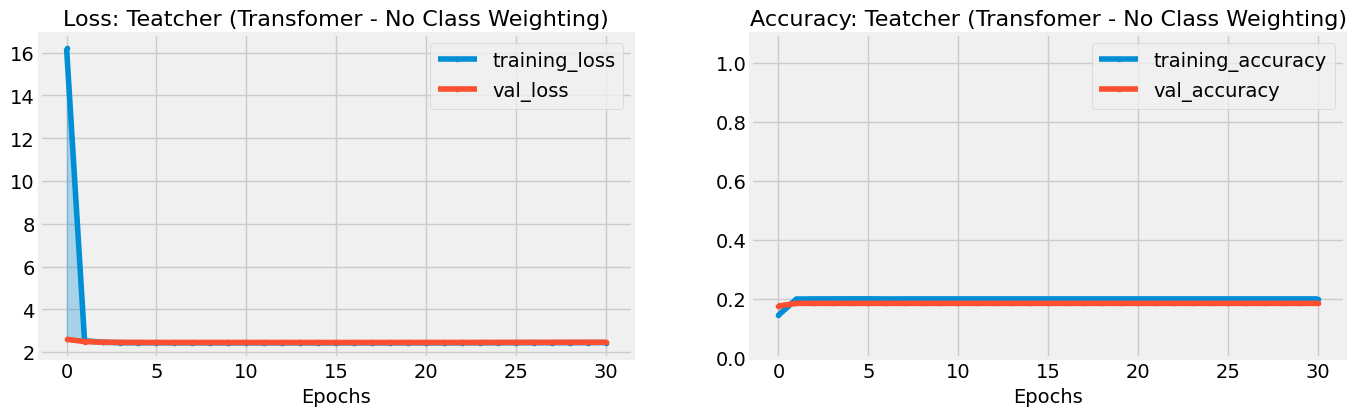

In [ ]:
plot_training_curves(history, 'Teatcher (Transfomer - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 39s 215ms/step - accuracy: 0.1481 - top5-acc: 0.5449 - Brier score: 1093.4026 - auc: 0.5916 - student_loss: 12.6638 - distillation_loss: 50.7072 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.1803 - val_auc: 0.6781 - val_student_loss: 2.4842 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 22s 193ms/step - accuracy: 0.1975 - top5-acc: 0.6504 - Brier score: 0.1488 - auc: 0.6835 - student_loss: 2.5911 - distillation_loss: 0.1767 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.1258 - val_auc: 0.6801 - val_student_loss: 2.6387 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 23s 201ms/step - accuracy: 0.1989 - top5-acc: 0.6524 - Brier score: 0.1924 - auc: 0.6986 - student_loss: 2.5013 - distillation_loss: 0.0763 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.2722 - val_auc: 0.6954 - val_student_loss: 2.4694 - lr: 0.0010
Epoch 4/100
112/112 

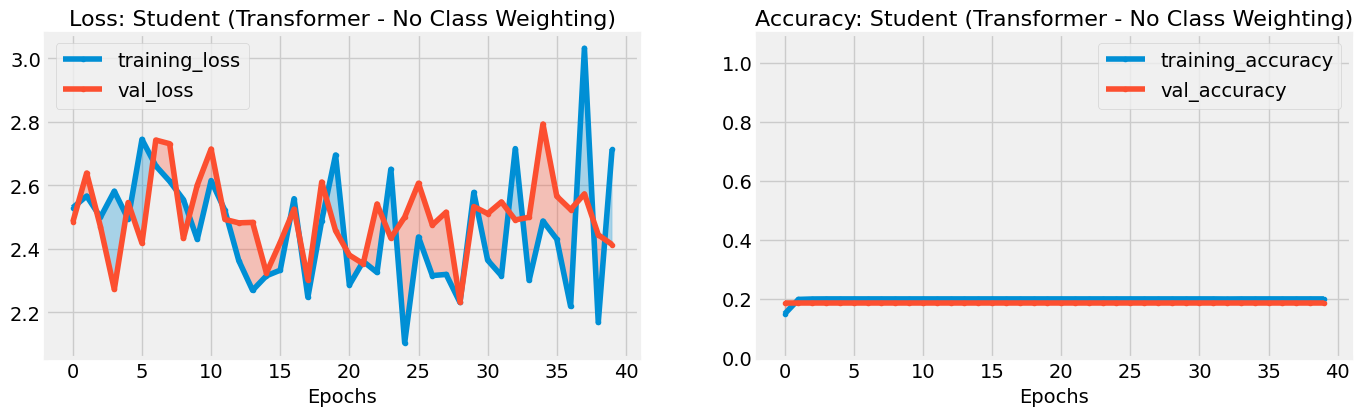

In [ ]:
plot_training_curves(history, 'Student (Transformer - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 49s 348ms/step - loss: 2.9001 - accuracy: 0.1866 - top5-acc: 0.6302 - Brier score: 0.5328 - auc: 0.6705 - val_loss: 2.5636 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.2171 - val_auc: 0.6778 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 37s 328ms/step - loss: 2.7358 - accuracy: 0.1838 - top5-acc: 0.6164 - Brier score: 0.1671 - auc: 0.5951 - val_loss: 2.6419 - val_accuracy: 0.1841 - val_top5-acc: 0.5791 - val_Brier score: 0.1453 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 37s 327ms/step - loss: 2.7164 - accuracy: 0.1207 - top5-acc: 0.4865 - Brier score: 0.1511 - auc: 0.5014 - val_loss: 2.6773 - val_accuracy: 0.1841 - val_top5-acc: 0.5062 - val_Brier score: 0.1308 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 37s 326ms/step - loss: 2.7106 - accuracy: 0.0665 - top5-acc: 0.3659 - Brier score: 0.1340 - auc: 0.499

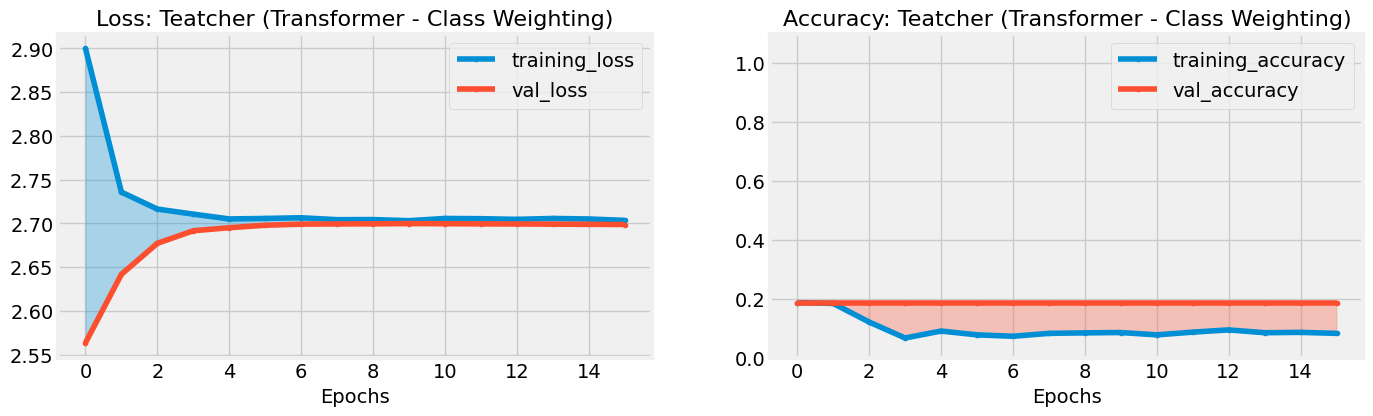

In [ ]:
plot_training_curves(history, 'Teatcher (Transformer - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 38s 216ms/step - accuracy: 0.1973 - top5-acc: 0.6428 - Brier score: 0.2107 - auc: 0.7039 - student_loss: 2.5338 - distillation_loss: 0.0102 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.1813 - val_auc: 0.7035 - val_student_loss: 2.5876 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 22s 195ms/step - accuracy: 0.1973 - top5-acc: 0.6481 - Brier score: 0.1855 - auc: 0.7074 - student_loss: 2.5350 - distillation_loss: 0.0031 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.1780 - val_auc: 0.7035 - val_student_loss: 2.4926 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 23s 201ms/step - accuracy: 0.1964 - top5-acc: 0.6510 - Brier score: 0.1850 - auc: 0.7072 - student_loss: 2.5350 - distillation_loss: 0.0028 - val_accuracy: 0.1841 - val_top5-acc: 0.6420 - val_Brier score: 0.1816 - val_auc: 0.7026 - val_student_loss: 2.5758 - lr: 0.0010
Epoch 4/100
112/112 [====

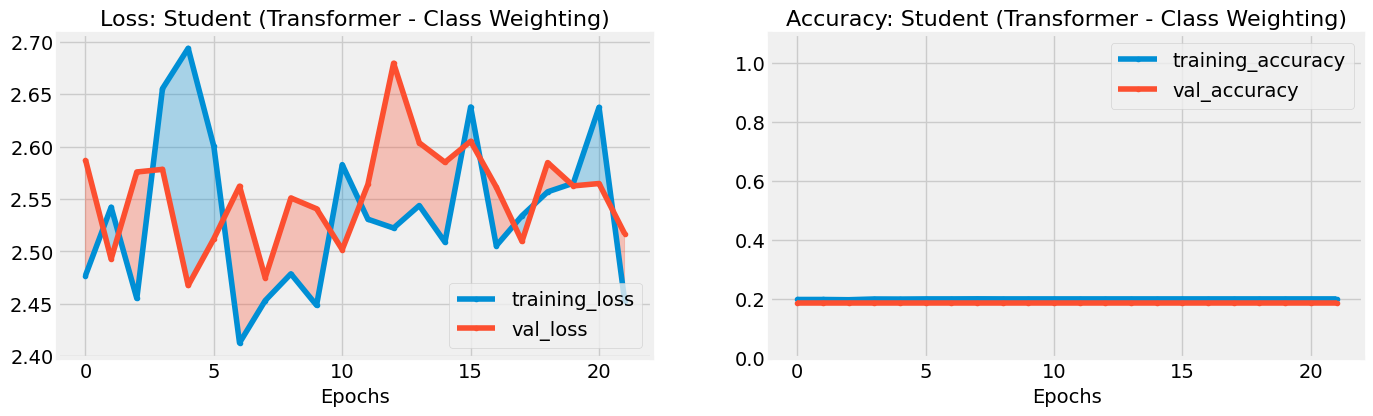

In [ ]:
plot_training_curves(history, 'Student (Transformer - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (neighborhood attention)



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 57s 376ms/step - loss: 5.8962 - accuracy: 0.3173 - top5-acc: 0.6843 - Brier score: 42.2474 - auc: 0.6944 - val_loss: 1.3393 - val_accuracy: 0.6016 - val_top5-acc: 0.8777 - val_Brier score: 3.8003 - val_auc: 0.8461 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 40s 355ms/step - loss: 1.6482 - accuracy: 0.6019 - top5-acc: 0.8925 - Brier score: 27.0058 - auc: 0.7853 - val_loss: 1.0224 - val_accuracy: 0.7048 - val_top5-acc: 0.9214 - val_Brier score: 4.9234 - val_auc: 0.8537 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 40s 356ms/step - loss: 1.1865 - accuracy: 0.7107 - top5-acc: 0.9425 - Brier score: 35.6913 - auc: 0.8113 - val_loss: 0.8512 - val_accuracy: 0.7486 - val_top5-acc: 0.9371 - val_Brier score: 10.5635 - val_auc: 0.8400 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 40s 356ms/step - loss: 0.9608 - accuracy: 0.7800 - top5-acc: 0.9663 - Brier score: 57.2724 - auc: 

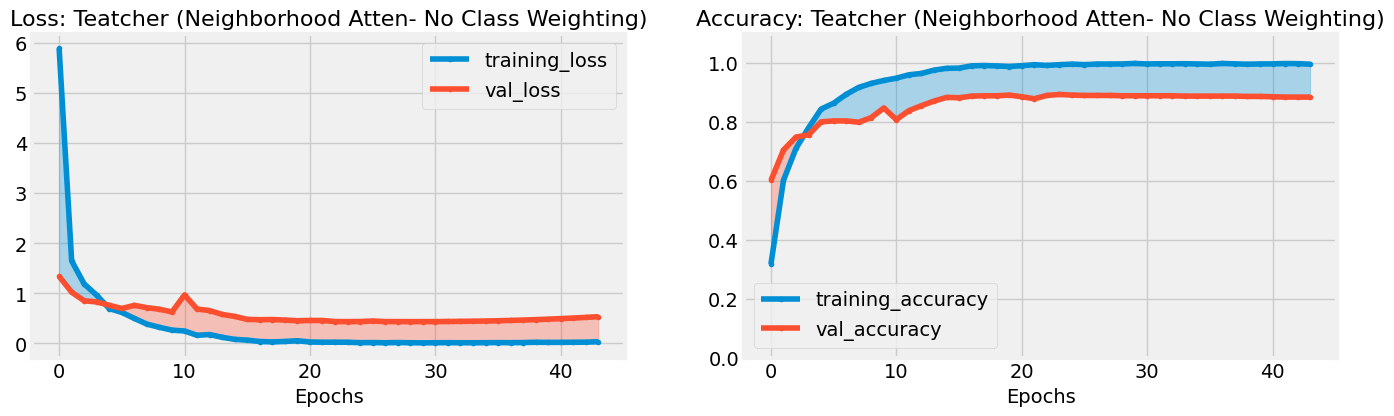

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 44s 241ms/step - accuracy: 0.3765 - top5-acc: 0.7337 - Brier score: 56.4299 - auc: 0.7104 - student_loss: 5.3476 - distillation_loss: 46.0844 - val_accuracy: 0.6420 - val_top5-acc: 0.8721 - val_Brier score: 16.4959 - val_auc: 0.8114 - val_student_loss: 1.6795 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 25s 225ms/step - accuracy: 0.6324 - top5-acc: 0.9052 - Brier score: 57.7893 - auc: 0.8112 - student_loss: 2.0179 - distillation_loss: 26.1247 - val_accuracy: 0.6689 - val_top5-acc: 0.8923 - val_Brier score: 15.7485 - val_auc: 0.8446 - val_student_loss: 0.7724 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 25s 225ms/step - accuracy: 0.7208 - top5-acc: 0.9444 - Brier score: 58.4005 - auc: 0.8349 - student_loss: 1.2692 - distillation_loss: 20.7598 - val_accuracy: 0.7127 - val_top5-acc: 0.9248 - val_Brier score: 12.6952 - val_auc: 0.8652 - val_student_loss: 0.9489 - lr: 0.0010
Epoch 4/100
112/

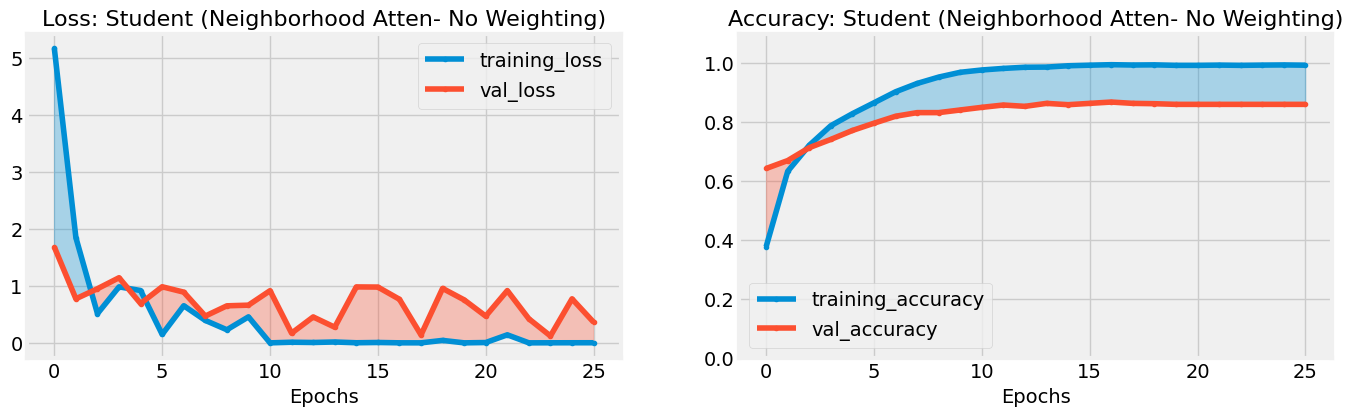

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- No Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 53s 374ms/step - loss: 0.4310 - accuracy: 0.9357 - top5-acc: 0.9955 - Brier score: 192.0757 - auc: 0.9374 - val_loss: 1.4167 - val_accuracy: 0.7576 - val_top5-acc: 0.9360 - val_Brier score: 144.0569 - val_auc: 0.8896 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 40s 357ms/step - loss: 0.9878 - accuracy: 0.8541 - top5-acc: 0.9871 - Brier score: 493.6837 - auc: 0.9387 - val_loss: 1.3121 - val_accuracy: 0.7654 - val_top5-acc: 0.9371 - val_Brier score: 211.6733 - val_auc: 0.8946 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 40s 357ms/step - loss: 0.7783 - accuracy: 0.8976 - top5-acc: 0.9916 - Brier score: 801.0583 - auc: 0.9534 - val_loss: 1.0786 - val_accuracy: 0.7935 - val_top5-acc: 0.9394 - val_Brier score: 225.9365 - val_auc: 0.9027 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 40s 353ms/step - loss: 0.5293 - accuracy: 0.9150 - top5-acc: 0.9944 - Brier score: 851.288

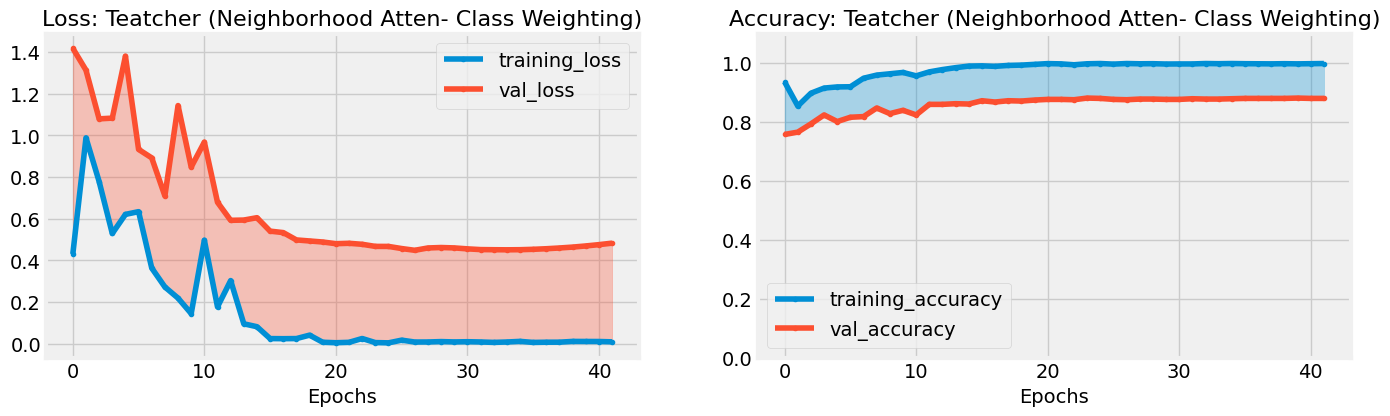

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 42s 242ms/step - accuracy: 0.9324 - top5-acc: 0.9949 - Brier score: 33.2242 - auc: 0.7758 - student_loss: 0.2415 - distillation_loss: 13.1253 - val_accuracy: 0.7946 - val_top5-acc: 0.9596 - val_Brier score: 15.9899 - val_auc: 0.7982 - val_student_loss: 1.1961 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 25s 218ms/step - accuracy: 0.9279 - top5-acc: 0.9938 - Brier score: 40.4539 - auc: 0.7399 - student_loss: 0.2551 - distillation_loss: 9.8208 - val_accuracy: 0.7946 - val_top5-acc: 0.9607 - val_Brier score: 16.4872 - val_auc: 0.7858 - val_student_loss: 0.3555 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 25s 226ms/step - accuracy: 0.9074 - top5-acc: 0.9913 - Brier score: 47.7996 - auc: 0.6986 - student_loss: 0.3221 - distillation_loss: 10.3917 - val_accuracy: 0.8070 - val_top5-acc: 0.9585 - val_Brier score: 16.3496 - val_auc: 0.7323 - val_student_loss: 0.4964 - lr: 0.0010
Epoch 4/100
112/1

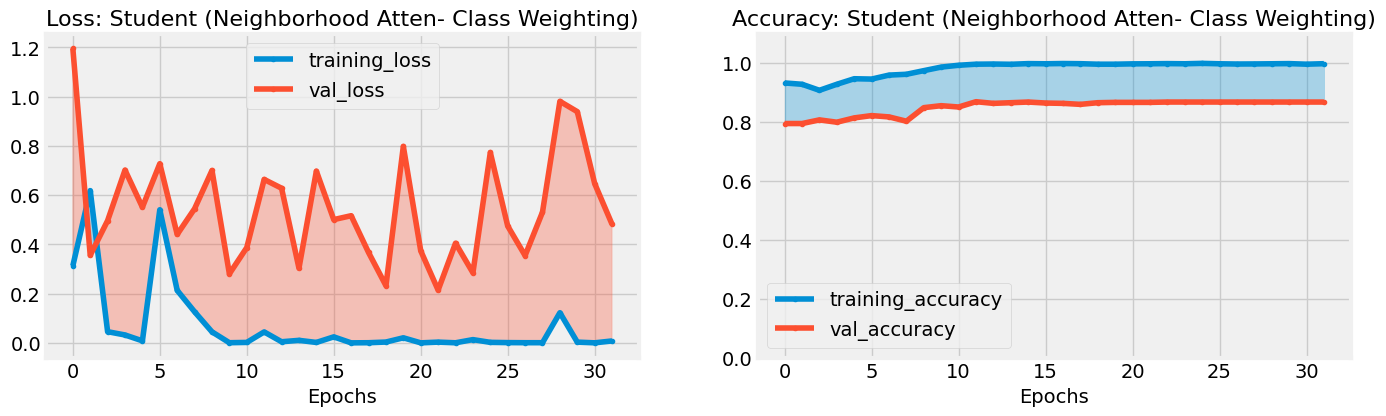

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 📂 Load BTDS-17C

In [ ]:
##################
NUM_CLASSES = 17
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_17Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4415 files belonging to 17 classes.
Using 3532 files for training.
Found 4415 files belonging to 17 classes.
Using 883 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4415 files belonging to 17 classes.


{0: 0.5700371651928745,
 1: 0.5110294117647058,
 2: 0.7562053723223393,
 3: 0.7583972719522591,
 4: 0.41863529411764705,
 5: 0.7952798140532809,
 6: 0.9619377162629758,
 7: 0.8991307863351526,
 8: 1.5482074486599373,
 9: 1.0024791525805725,
 10: 2.3361344537815127,
 11: 1.721362229102167,
 12: 5.450980392156863,
 13: 4.590299277605779,
 14: 1.7101114955786236,
 15: 1.348696179502729,
 16: 2.127211860353898}

## ◼ No Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = False)

Epoch 1/100
111/111 [==============================] - 268s 2s/step - loss: 785.8714 - accuracy: 0.2990 - top5-acc: 0.6042 - Brier score: 3578643.2500 - auc: 0.6469 - val_loss: 45.5372 - val_accuracy: 0.6014 - val_top5-acc: 0.8743 - val_Brier score: 35957.6953 - val_auc: 0.7733 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 5s 40ms/step - loss: 18.4840 - accuracy: 0.7659 - top5-acc: 0.9533 - Brier score: 33545.2227 - auc: 0.7980 - val_loss: 46.4111 - val_accuracy: 0.5493 - val_top5-acc: 0.8505 - val_Brier score: 28963.4980 - val_auc: 0.7675 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 5s 40ms/step - loss: 10.5949 - accuracy: 0.8310 - top5-acc: 0.9768 - Brier score: 33730.0117 - auc: 0.8151 - val_loss: 32.8241 - val_accuracy: 0.6772 - val_top5-acc: 0.9377 - val_Brier score: 30454.2812 - val_auc: 0.7746 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 5s 40ms/step - loss: 4.8191 - accuracy: 0.9046 - top5-acc: 0.9912 - Brier s

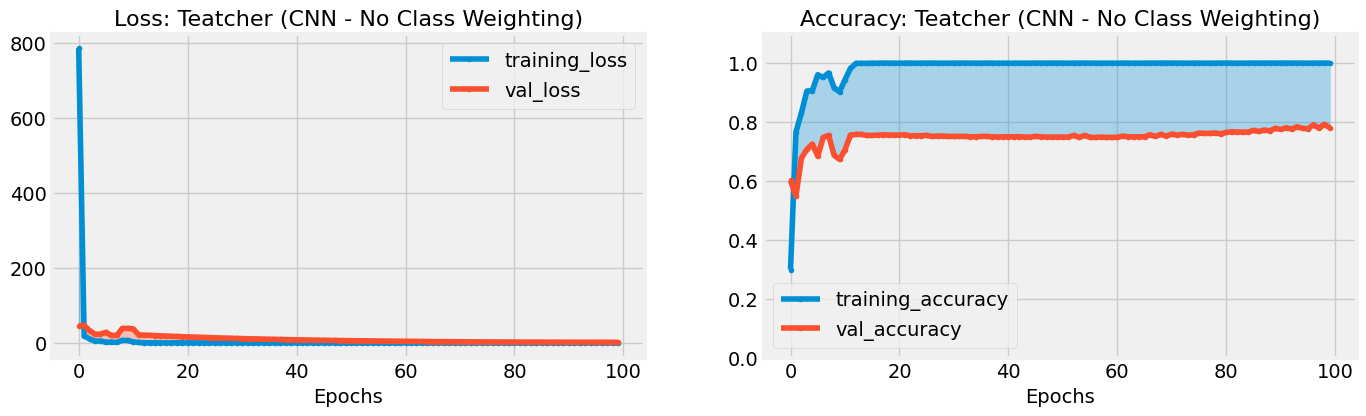

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
111/111 [==============================] - 6s 29ms/step - accuracy: 0.1569 - top5-acc: 0.4176 - Brier score: 1361099.8750 - auc: 0.5408 - student_loss: 1001.5577 - distillation_loss: 1124.7005 - val_accuracy: 0.2129 - val_top5-acc: 0.5006 - val_Brier score: 82329.7734 - val_auc: 0.5479 - val_student_loss: 147.7102 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 3s 26ms/step - accuracy: 0.3624 - top5-acc: 0.6486 - Brier score: 77896.5547 - auc: 0.6083 - student_loss: 163.4428 - distillation_loss: 774.5312 - val_accuracy: 0.3160 - val_top5-acc: 0.6897 - val_Brier score: 2606.6235 - val_auc: 0.6667 - val_student_loss: 28.3688 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 3s 27ms/step - accuracy: 0.4935 - top5-acc: 0.7956 - Brier score: 1145.8499 - auc: 0.6932 - student_loss: 11.4218 - distillation_loss: 120.9727 - val_accuracy: 0.5096 - val_top5-acc: 0.8358 - val_Brier score: 378.7145 - val_auc: 0.6868 - val_student_loss: 4.3712 - lr: 

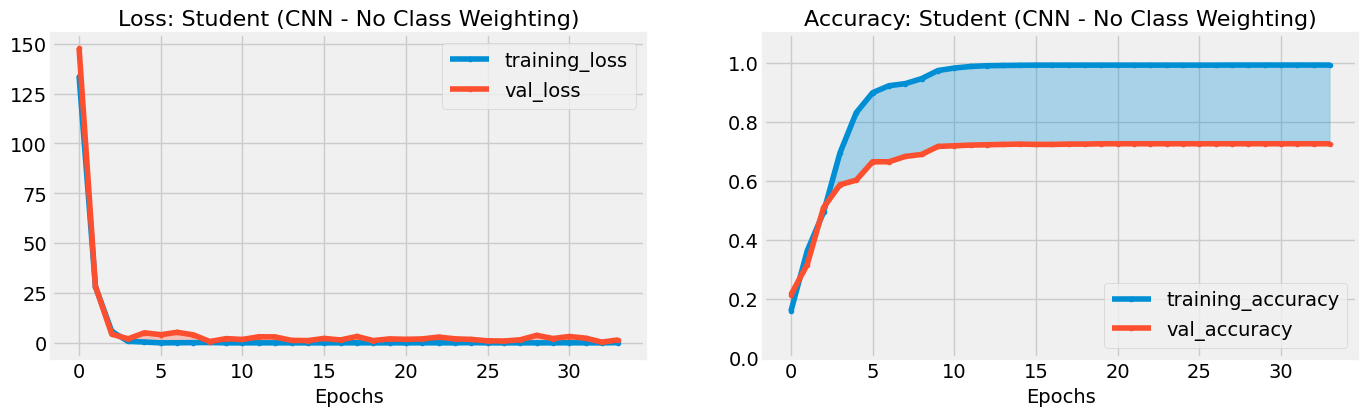

In [ ]:
plot_training_curves(history, 'Student (CNN - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = True)

Epoch 1/100
111/111 [==============================] - 6s 43ms/step - loss: 161.8869 - accuracy: 0.4020 - top5-acc: 0.7203 - Brier score: 104833.6797 - auc: 0.6608 - val_loss: 46.5641 - val_accuracy: 0.6048 - val_top5-acc: 0.8732 - val_Brier score: 37007.5352 - val_auc: 0.6467 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 5s 40ms/step - loss: 12.5848 - accuracy: 0.7862 - top5-acc: 0.9683 - Brier score: 22709.2422 - auc: 0.7113 - val_loss: 19.4743 - val_accuracy: 0.7044 - val_top5-acc: 0.9320 - val_Brier score: 12545.3662 - val_auc: 0.6930 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 5s 40ms/step - loss: 3.8124 - accuracy: 0.8845 - top5-acc: 0.9918 - Brier score: 13937.6484 - auc: 0.7084 - val_loss: 17.4629 - val_accuracy: 0.6931 - val_top5-acc: 0.9309 - val_Brier score: 9010.5420 - val_auc: 0.7550 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 5s 40ms/step - loss: 2.0064 - accuracy: 0.9159 - top5-acc: 0.9963 - Brier scor

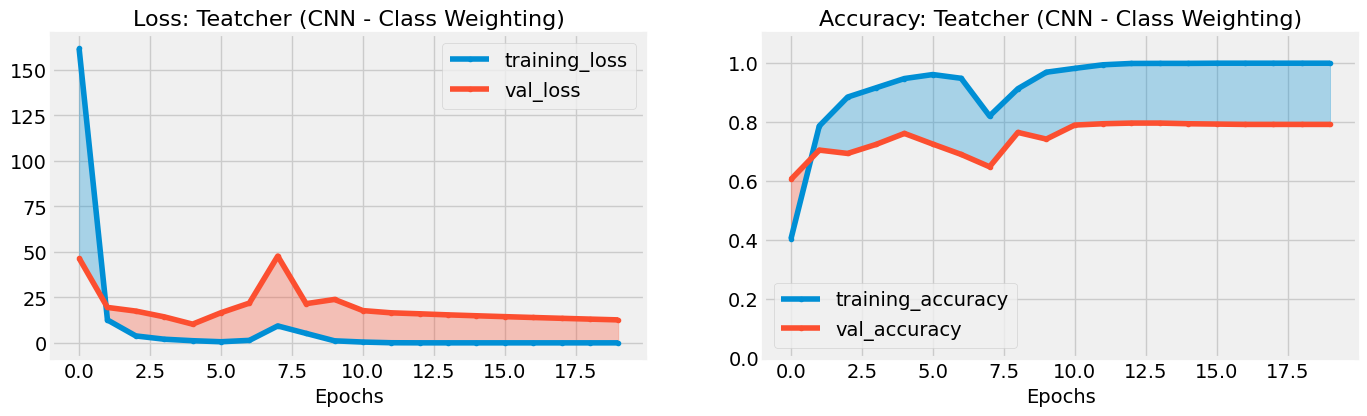

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
111/111 [==============================] - 5s 28ms/step - accuracy: 0.7871 - top5-acc: 0.9584 - Brier score: 1807.1776 - auc: 0.8051 - student_loss: 5.2354 - distillation_loss: 72.3676 - val_accuracy: 0.6976 - val_top5-acc: 0.9422 - val_Brier score: 1937.7169 - val_auc: 0.7916 - val_student_loss: 8.0776 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 3s 28ms/step - accuracy: 0.9128 - top5-acc: 0.9907 - Brier score: 2529.5303 - auc: 0.8025 - student_loss: 3.5579 - distillation_loss: 25.1936 - val_accuracy: 0.7203 - val_top5-acc: 0.9570 - val_Brier score: 2043.2191 - val_auc: 0.7631 - val_student_loss: 6.3032 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 3s 26ms/step - accuracy: 0.9287 - top5-acc: 0.9932 - Brier score: 2614.8901 - auc: 0.8015 - student_loss: 2.7876 - distillation_loss: 18.5739 - val_accuracy: 0.7305 - val_top5-acc: 0.9298 - val_Brier score: 1964.8457 - val_auc: 0.7654 - val_student_loss: 6.7068 - lr: 0.0010
Epoch 4/10

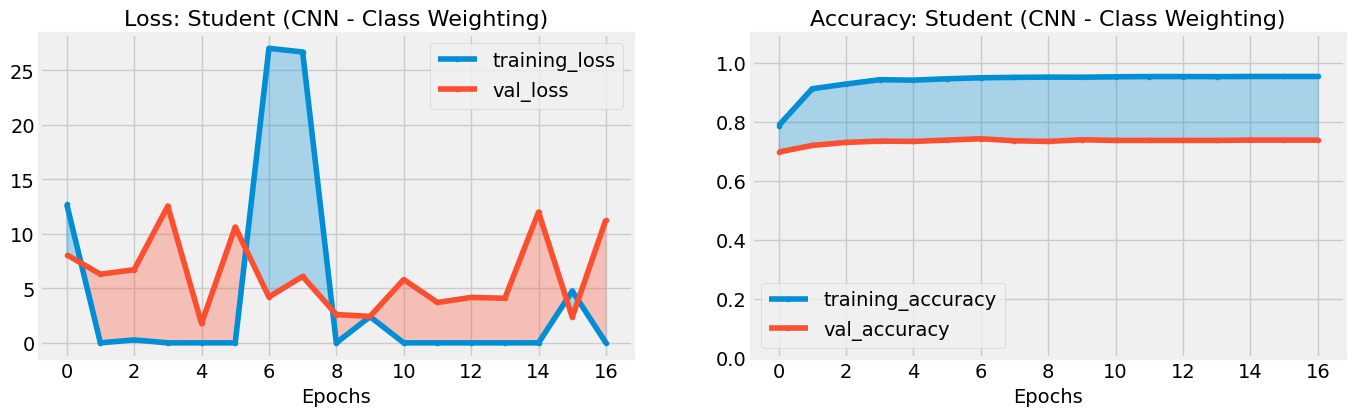

In [ ]:
plot_training_curves(history, 'Student (CNN - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (Multi-head Self-Attention)



In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
#vanilla=True ====> traditional transformer with multi-head self attention
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=True)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=True)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
111/111 [==============================] - 50s 350ms/step - loss: 16.5315 - accuracy: 0.0974 - top5-acc: 0.4066 - Brier score: 332.7122 - auc: 0.5644 - val_loss: 2.7863 - val_accuracy: 0.1291 - val_top5-acc: 0.5017 - val_Brier score: 0.0619 - val_auc: 0.6498 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 37s 332ms/step - loss: 2.7330 - accuracy: 0.1447 - top5-acc: 0.5042 - Brier score: 0.0942 - auc: 0.6597 - val_loss: 2.7111 - val_accuracy: 0.1291 - val_top5-acc: 0.4915 - val_Brier score: 0.1445 - val_auc: 0.6500 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 37s 332ms/step - loss: 2.6767 - accuracy: 0.1447 - top5-acc: 0.5139 - Brier score: 0.2010 - auc: 0.6650 - val_loss: 2.6880 - val_accuracy: 0.1291 - val_top5-acc: 0.4915 - val_Brier score: 0.2671 - val_auc: 0.6501 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 37s 332ms/step - loss: 2.6608 - accuracy: 0.1444 - top5-acc: 0.5082 - Brier score: 0.3143 - auc: 0.

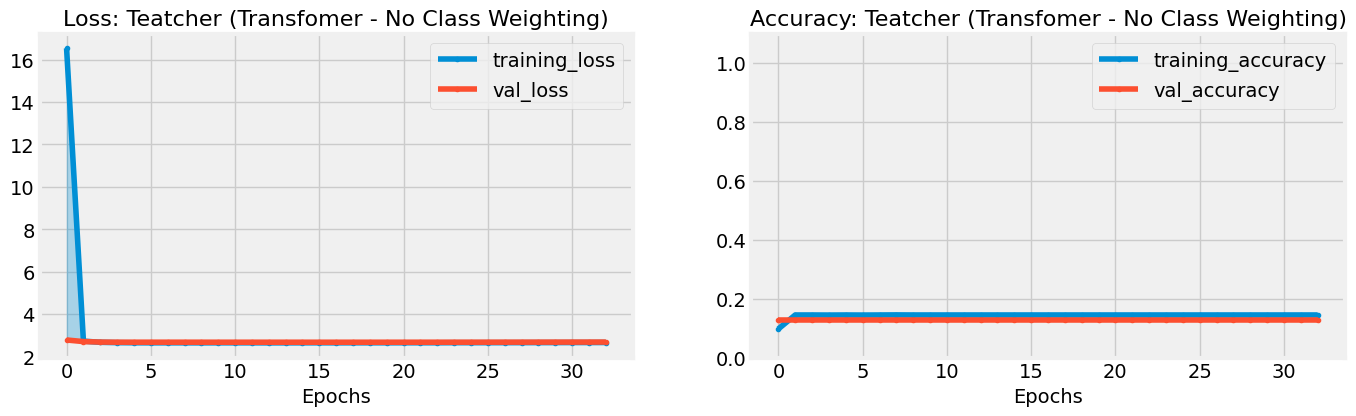

In [ ]:
plot_training_curves(history, 'Teatcher (Transfomer - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
111/111 [==============================] - 39s 220ms/step - accuracy: 0.0985 - top5-acc: 0.4236 - Brier score: 409.8674 - auc: 0.5646 - student_loss: 11.1307 - distillation_loss: 45.5417 - val_accuracy: 0.1291 - val_top5-acc: 0.5051 - val_Brier score: 0.0674 - val_auc: 0.6494 - val_student_loss: 2.7595 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 23s 201ms/step - accuracy: 0.1447 - top5-acc: 0.5034 - Brier score: 0.0949 - auc: 0.6602 - student_loss: 2.7365 - distillation_loss: 0.0839 - val_accuracy: 0.1291 - val_top5-acc: 0.5051 - val_Brier score: 0.1340 - val_auc: 0.6504 - val_student_loss: 2.7993 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 22s 201ms/step - accuracy: 0.1444 - top5-acc: 0.5082 - Brier score: 0.1887 - auc: 0.6650 - student_loss: 2.6829 - distillation_loss: 0.0283 - val_accuracy: 0.1291 - val_top5-acc: 0.5051 - val_Brier score: 0.2507 - val_auc: 0.6512 - val_student_loss: 2.6328 - lr: 0.0010
Epoch 4/100
111/111 [

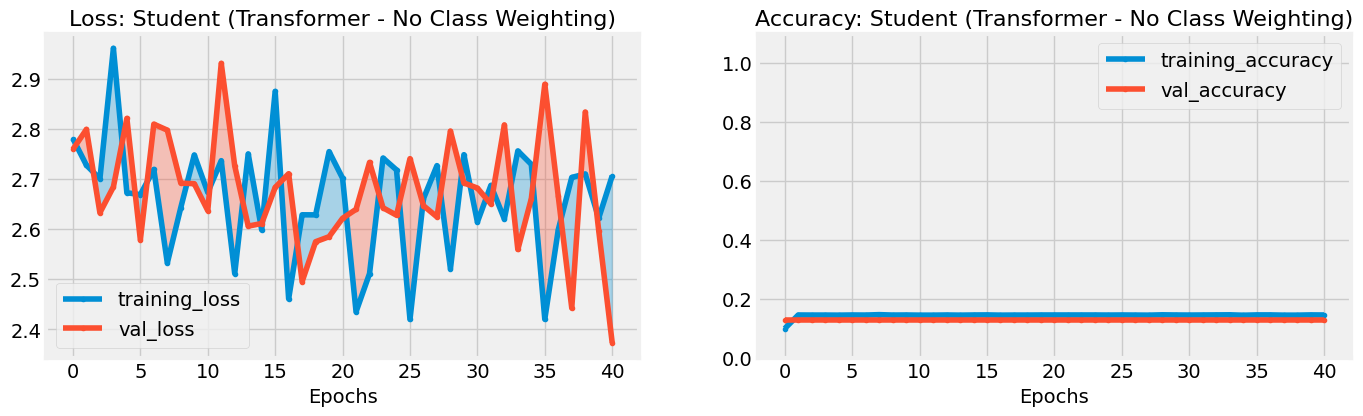

In [ ]:
plot_training_curves(history, 'Student (Transformer - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
111/111 [==============================] - 49s 347ms/step - loss: 2.9902 - accuracy: 0.1384 - top5-acc: 0.4887 - Brier score: 0.5063 - auc: 0.6392 - val_loss: 2.7287 - val_accuracy: 0.1291 - val_top5-acc: 0.4790 - val_Brier score: 0.1733 - val_auc: 0.6402 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 37s 328ms/step - loss: 2.8473 - accuracy: 0.1430 - top5-acc: 0.4870 - Brier score: 0.1290 - auc: 0.6062 - val_loss: 2.7785 - val_accuracy: 0.1291 - val_top5-acc: 0.4315 - val_Brier score: 0.1097 - val_auc: 0.5396 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 37s 328ms/step - loss: 2.8292 - accuracy: 0.1144 - top5-acc: 0.4357 - Brier score: 0.1011 - auc: 0.5198 - val_loss: 2.8089 - val_accuracy: 0.1291 - val_top5-acc: 0.3918 - val_Brier score: 0.0979 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 37s 328ms/step - loss: 2.8273 - accuracy: 0.0770 - top5-acc: 0.3649 - Brier score: 0.0963 - auc: 0.501

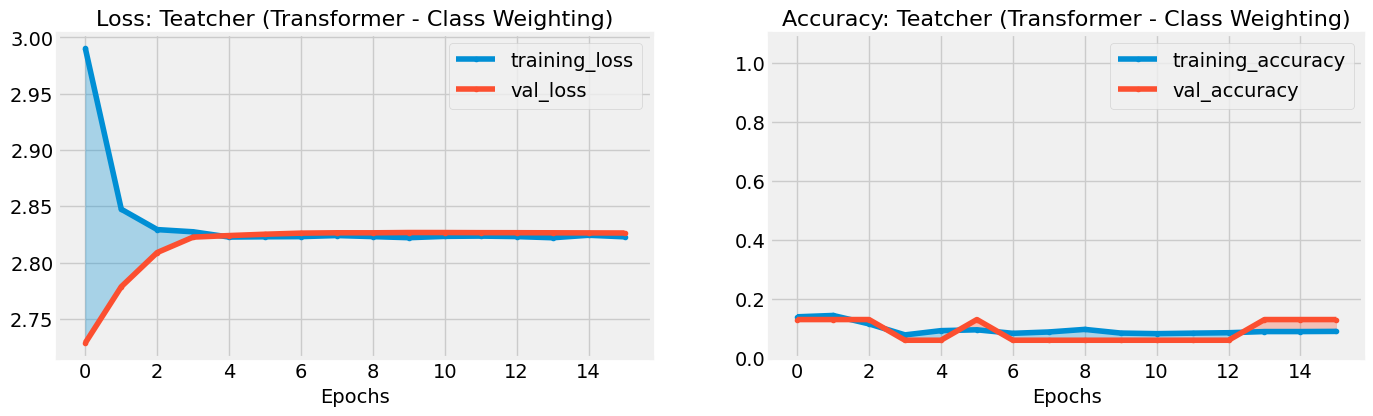

In [ ]:
plot_training_curves(history, 'Teatcher (Transformer - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
111/111 [==============================] - 39s 217ms/step - accuracy: 0.1424 - top5-acc: 0.5045 - Brier score: 0.1786 - auc: 0.6619 - student_loss: 2.7031 - distillation_loss: 0.0066 - val_accuracy: 0.1291 - val_top5-acc: 0.4892 - val_Brier score: 0.1581 - val_auc: 0.6483 - val_student_loss: 2.6496 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 23s 202ms/step - accuracy: 0.1435 - top5-acc: 0.5003 - Brier score: 0.1599 - auc: 0.6614 - student_loss: 2.7048 - distillation_loss: 0.0018 - val_accuracy: 0.1291 - val_top5-acc: 0.4892 - val_Brier score: 0.1580 - val_auc: 0.6483 - val_student_loss: 2.7023 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 22s 195ms/step - accuracy: 0.1447 - top5-acc: 0.4975 - Brier score: 0.1604 - auc: 0.6622 - student_loss: 2.7048 - distillation_loss: 0.0017 - val_accuracy: 0.1291 - val_top5-acc: 0.4892 - val_Brier score: 0.1597 - val_auc: 0.6481 - val_student_loss: 2.7061 - lr: 0.0010
Epoch 4/100
111/111 [====

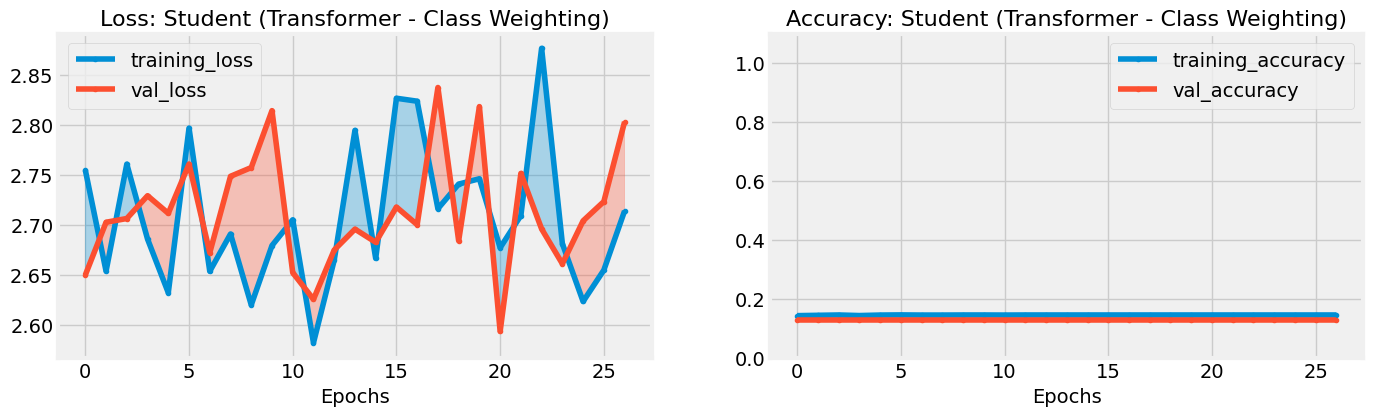

In [ ]:
plot_training_curves(history, 'Student (Transformer - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (neighborhood attention)



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
111/111 [==============================] - 53s 377ms/step - loss: 6.3772 - accuracy: 0.2834 - top5-acc: 0.6322 - Brier score: 47.0207 - auc: 0.6873 - val_loss: 1.6536 - val_accuracy: 0.5130 - val_top5-acc: 0.8222 - val_Brier score: 2.9188 - val_auc: 0.8210 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 40s 359ms/step - loss: 2.0122 - accuracy: 0.5088 - top5-acc: 0.8474 - Brier score: 21.3839 - auc: 0.7876 - val_loss: 1.2971 - val_accuracy: 0.5968 - val_top5-acc: 0.8890 - val_Brier score: 6.3159 - val_auc: 0.8547 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 40s 359ms/step - loss: 1.4307 - accuracy: 0.6345 - top5-acc: 0.9063 - Brier score: 27.7078 - auc: 0.8186 - val_loss: 1.1973 - val_accuracy: 0.6455 - val_top5-acc: 0.9253 - val_Brier score: 7.7177 - val_auc: 0.8518 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 40s 359ms/step - loss: 1.1160 - accuracy: 0.7030 - top5-acc: 0.9414 - Brier score: 33.8473 - auc: 0

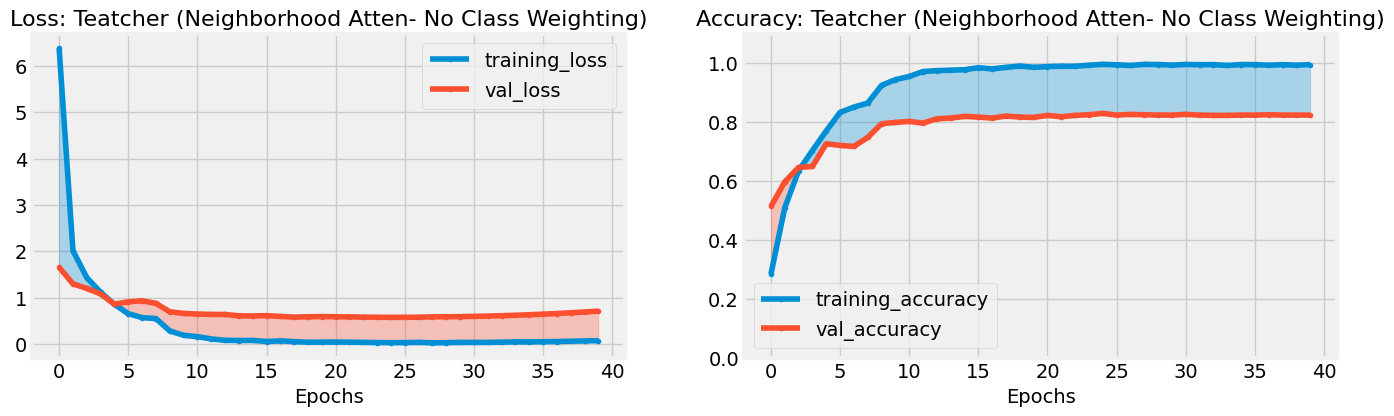

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
111/111 [==============================] - 43s 243ms/step - accuracy: 0.3021 - top5-acc: 0.6764 - Brier score: 33.2154 - auc: 0.6944 - student_loss: 4.8310 - distillation_loss: 22.5697 - val_accuracy: 0.5255 - val_top5-acc: 0.8743 - val_Brier score: 4.2229 - val_auc: 0.8434 - val_student_loss: 1.4630 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 25s 228ms/step - accuracy: 0.4997 - top5-acc: 0.8531 - Brier score: 23.1403 - auc: 0.7911 - student_loss: 2.0892 - distillation_loss: 12.6450 - val_accuracy: 0.5889 - val_top5-acc: 0.8822 - val_Brier score: 5.1314 - val_auc: 0.8564 - val_student_loss: 1.0610 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 25s 227ms/step - accuracy: 0.5651 - top5-acc: 0.8981 - Brier score: 21.8242 - auc: 0.8133 - student_loss: 1.5547 - distillation_loss: 10.7252 - val_accuracy: 0.5776 - val_top5-acc: 0.9071 - val_Brier score: 6.1501 - val_auc: 0.8550 - val_student_loss: 1.2495 - lr: 0.0010
Epoch 4/100
111/111

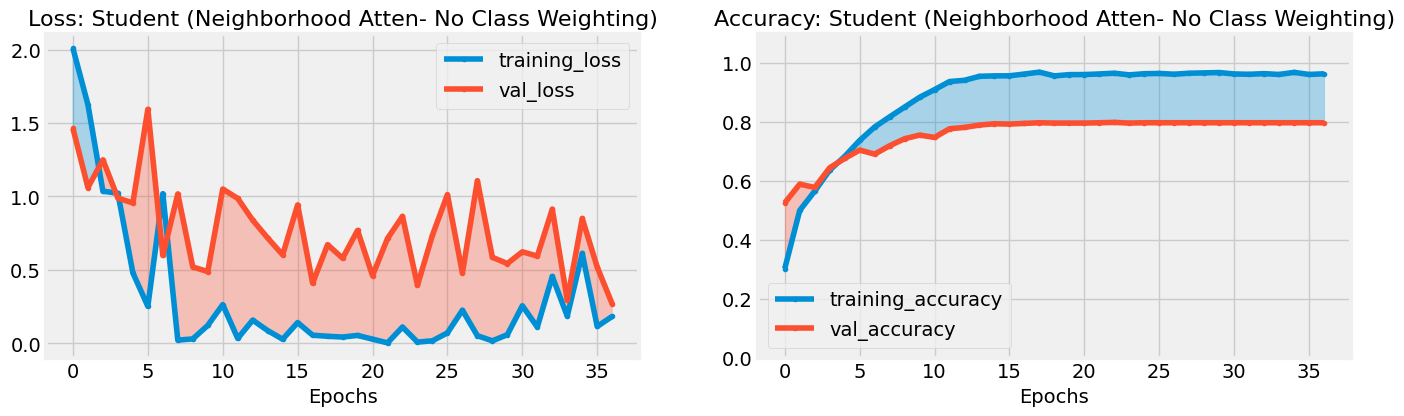

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
111/111 [==============================] - 54s 375ms/step - loss: 0.7793 - accuracy: 0.8528 - top5-acc: 0.9807 - Brier score: 118.1068 - auc: 0.9204 - val_loss: 1.4971 - val_accuracy: 0.6772 - val_top5-acc: 0.9105 - val_Brier score: 77.5594 - val_auc: 0.8824 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 39s 354ms/step - loss: 1.5779 - accuracy: 0.7591 - top5-acc: 0.9581 - Brier score: 252.2895 - auc: 0.9063 - val_loss: 1.6220 - val_accuracy: 0.6840 - val_top5-acc: 0.9298 - val_Brier score: 100.0748 - val_auc: 0.8847 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 39s 353ms/step - loss: 1.1356 - accuracy: 0.8228 - top5-acc: 0.9768 - Brier score: 329.1891 - auc: 0.9320 - val_loss: 1.6586 - val_accuracy: 0.6569 - val_top5-acc: 0.9241 - val_Brier score: 91.0690 - val_auc: 0.8657 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 40s 358ms/step - loss: 0.6201 - accuracy: 0.8822 - top5-acc: 0.9884 - Brier score: 320.4960 

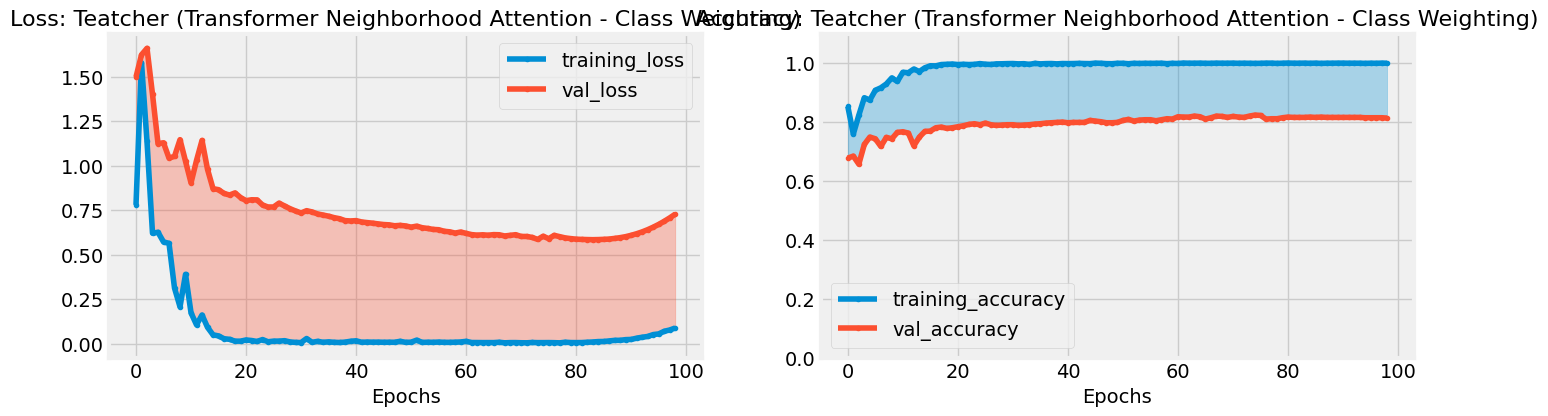

In [ ]:
plot_training_curves(history, 'Teatcher (Transformer Neighborhood Attention - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
111/111 [==============================] - 43s 243ms/step - accuracy: 0.8587 - top5-acc: 0.9836 - Brier score: 11.0356 - auc: 0.7340 - student_loss: 0.4909 - distillation_loss: 3.2170 - val_accuracy: 0.7293 - val_top5-acc: 0.9547 - val_Brier score: 4.8280 - val_auc: 0.7913 - val_student_loss: 0.8515 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 25s 220ms/step - accuracy: 0.8559 - top5-acc: 0.9844 - Brier score: 14.8238 - auc: 0.6517 - student_loss: 0.4758 - distillation_loss: 2.7371 - val_accuracy: 0.7588 - val_top5-acc: 0.9581 - val_Brier score: 6.5936 - val_auc: 0.7051 - val_student_loss: 0.3031 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 25s 227ms/step - accuracy: 0.8800 - top5-acc: 0.9907 - Brier score: 18.7263 - auc: 0.5932 - student_loss: 0.4054 - distillation_loss: 2.5822 - val_accuracy: 0.7678 - val_top5-acc: 0.9672 - val_Brier score: 6.0756 - val_auc: 0.6790 - val_student_loss: 0.5721 - lr: 0.0010
Epoch 4/100
111/111 [=

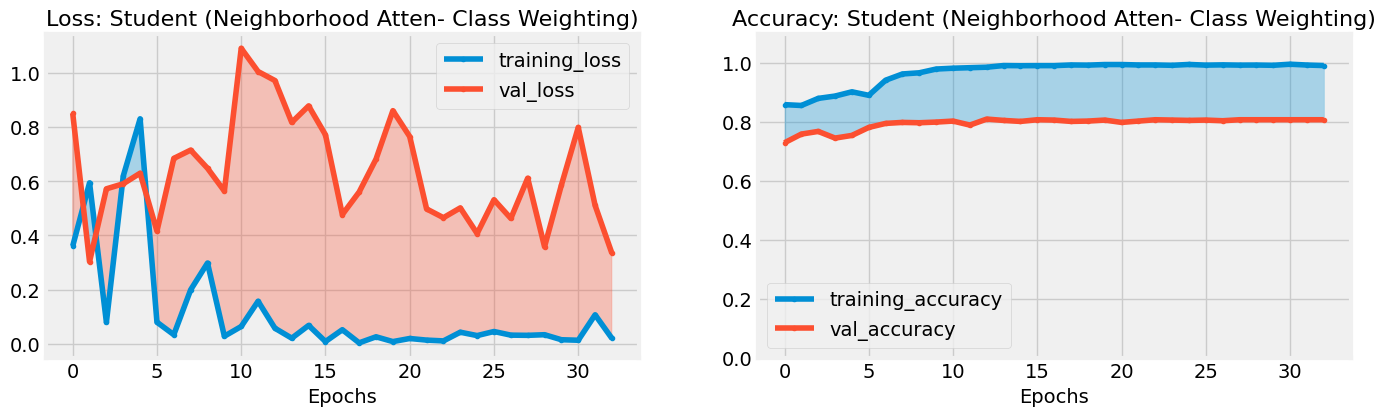

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 📂 Load BTDS-44C

In [ ]:
##################
NUM_CLASSES = 44
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_44Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4478 files belonging to 44 classes.
Using 3583 files for training.
Found 4478 files belonging to 44 classes.
Using 895 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4478 files belonging to 44 classes.


{0: 0.57838326446281,
 1: 0.4368903628560281,
 2: 0.5952950558213717,
 3: 1.5423553719008265,
 4: 0.908887987012987,
 5: 1.3944582814445827,
 6: 2.262121212121212,
 7: 2.1207386363636362,
 8: 1.7858851674641147,
 9: 5.089772727272727,
 10: 5.65530303030303,
 11: 4.425889328063241,
 12: 3.7702020202020203,
 13: 2.5448863636363637,
 14: 3.084710743801653,
 15: 1.8508264462809918,
 16: 1.0829303675048356,
 17: 1.8508264462809918,
 18: 3.393181818181818,
 19: 3.283724340175953,
 20: 5.987967914438503,
 21: 4.425889328063241,
 22: 1.5193351424694708,
 23: 2.4828159645232817,
 24: 0.37424799465240643,
 25: 0.27586844050258685,
 26: 0.4368903628560281,
 27: 0.7830419580419581,
 28: 0.4564818589482267,
 29: 0.9788024475524476,
 30: 1.1836680761099365,
 31: 1.4138257575757576,
 32: 1.5423553719008265,
 33: 1.5423553719008265,
 34: 0.9425505050505051,
 35: 1.6158008658008658,
 36: 0.6878071253071253,
 37: 0.5247188378631678,
 38: 0.8276053215077606,
 39: 3.635551948051948,
 40: 1.211850649350649

## ◼ No Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 288s 2s/step - loss: 937.0530 - accuracy: 0.2824 - top5-acc: 0.4962 - Brier score: 2720860.0000 - auc: 0.6521 - val_loss: 74.7957 - val_accuracy: 0.5631 - val_top5-acc: 0.8145 - val_Brier score: 49467.3281 - val_auc: 0.8238 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 42ms/step - loss: 36.5326 - accuracy: 0.7374 - top5-acc: 0.9177 - Brier score: 57263.4492 - auc: 0.8141 - val_loss: 107.8631 - val_accuracy: 0.5665 - val_top5-acc: 0.7832 - val_Brier score: 67721.3359 - val_auc: 0.7352 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 43ms/step - loss: 17.9649 - accuracy: 0.8406 - top5-acc: 0.9699 - Brier score: 57257.3477 - auc: 0.8278 - val_loss: 54.1777 - val_accuracy: 0.6916 - val_top5-acc: 0.8793 - val_Brier score: 48199.0586 - val_auc: 0.7727 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 5s 42ms/step - loss: 18.2597 - accuracy: 0.8607 - top5-acc: 0.9707 - Brier

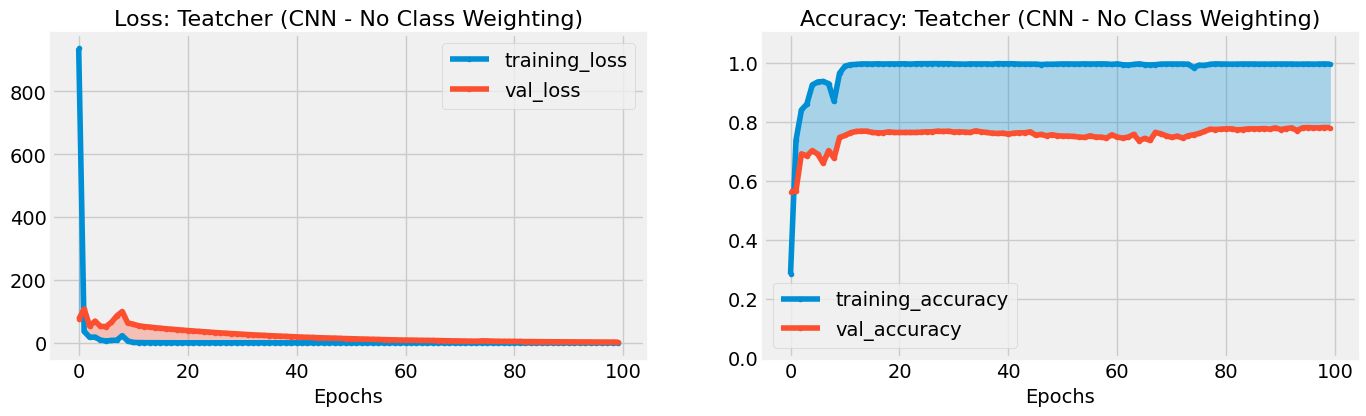

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 5s 32ms/step - accuracy: 0.1881 - top5-acc: 0.3692 - Brier score: 268747.6875 - auc: 0.5881 - student_loss: 369.2316 - distillation_loss: 663.5994 - val_accuracy: 0.4235 - val_top5-acc: 0.6626 - val_Brier score: 548.6254 - val_auc: 0.6748 - val_student_loss: 13.8361 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 3s 27ms/step - accuracy: 0.5825 - top5-acc: 0.7968 - Brier score: 384.3102 - auc: 0.7211 - student_loss: 7.1843 - distillation_loss: 70.5787 - val_accuracy: 0.5587 - val_top5-acc: 0.7765 - val_Brier score: 238.9841 - val_auc: 0.7013 - val_student_loss: 4.4816 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 3s 27ms/step - accuracy: 0.7142 - top5-acc: 0.8920 - Brier score: 271.7794 - auc: 0.7491 - student_loss: 3.9897 - distillation_loss: 42.5568 - val_accuracy: 0.6000 - val_top5-acc: 0.8279 - val_Brier score: 184.4142 - val_auc: 0.7292 - val_student_loss: 14.2363 - lr: 0.0010
Epoch 4/

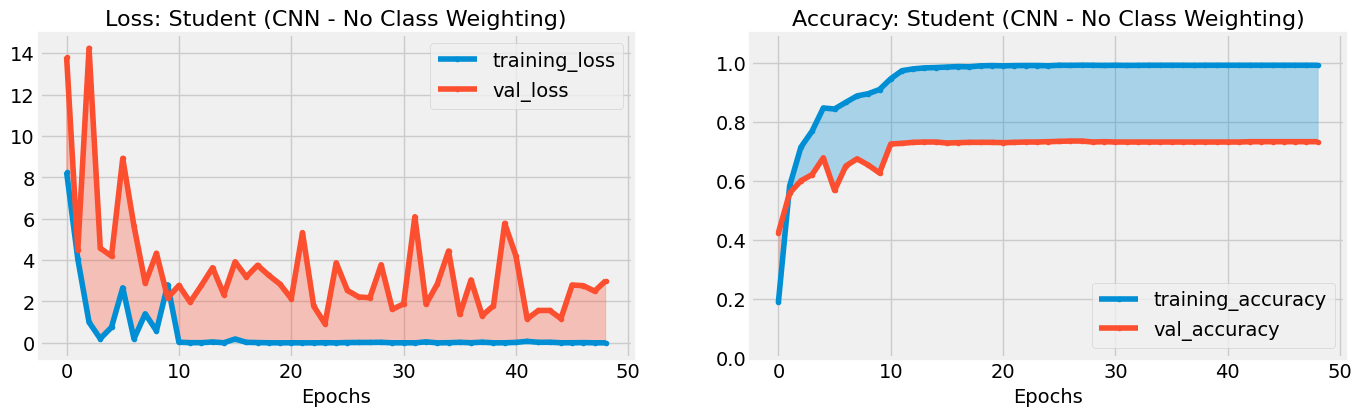

In [ ]:
plot_training_curves(history, 'Student (CNN - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 6s 47ms/step - loss: 363.5276 - accuracy: 0.3472 - top5-acc: 0.5744 - Brier score: 303739.6562 - auc: 0.6630 - val_loss: 92.5532 - val_accuracy: 0.4648 - val_top5-acc: 0.7218 - val_Brier score: 34491.3555 - val_auc: 0.6596 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 43ms/step - loss: 27.2820 - accuracy: 0.7067 - top5-acc: 0.9004 - Brier score: 28319.7500 - auc: 0.7634 - val_loss: 44.8374 - val_accuracy: 0.6849 - val_top5-acc: 0.8827 - val_Brier score: 25350.4531 - val_auc: 0.7349 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 43ms/step - loss: 12.9857 - accuracy: 0.8390 - top5-acc: 0.9657 - Brier score: 29236.8008 - auc: 0.7819 - val_loss: 42.3179 - val_accuracy: 0.6804 - val_top5-acc: 0.8883 - val_Brier score: 25142.4688 - val_auc: 0.8031 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 5s 43ms/step - loss: 6.0625 - accuracy: 0.9020 - top5-acc: 0.9841 - Brier sc

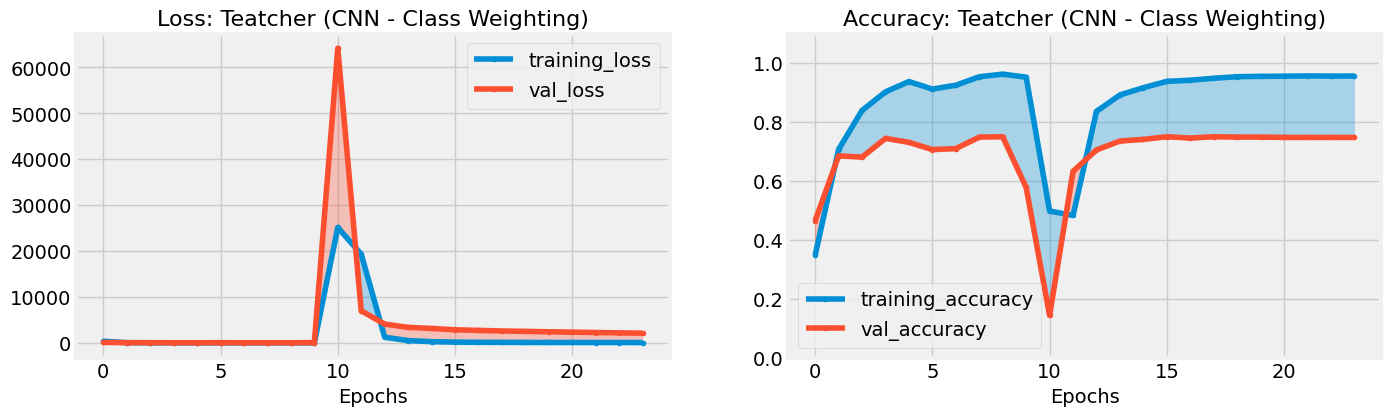

In [ ]:
plot_training_curves(history, 'Teatcher (CNN - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 5s 30ms/step - accuracy: 0.8186 - top5-acc: 0.9442 - Brier score: 1962.7151 - auc: 0.8598 - student_loss: 4.4702 - distillation_loss: 72.2623 - val_accuracy: 0.7531 - val_top5-acc: 0.9095 - val_Brier score: 2355.8687 - val_auc: 0.8774 - val_student_loss: 19.8346 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 3s 25ms/step - accuracy: 0.9445 - top5-acc: 0.9902 - Brier score: 3290.0574 - auc: 0.8935 - student_loss: 3.4727 - distillation_loss: 23.1320 - val_accuracy: 0.7296 - val_top5-acc: 0.9106 - val_Brier score: 3391.9646 - val_auc: 0.8827 - val_student_loss: 7.8711 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 3s 26ms/step - accuracy: 0.9595 - top5-acc: 0.9913 - Brier score: 3810.7405 - auc: 0.9048 - student_loss: 3.4162 - distillation_loss: 16.3578 - val_accuracy: 0.7542 - val_top5-acc: 0.9196 - val_Brier score: 3553.9087 - val_auc: 0.8854 - val_student_loss: 9.5722 - lr: 0.0010
Epoch 4/1

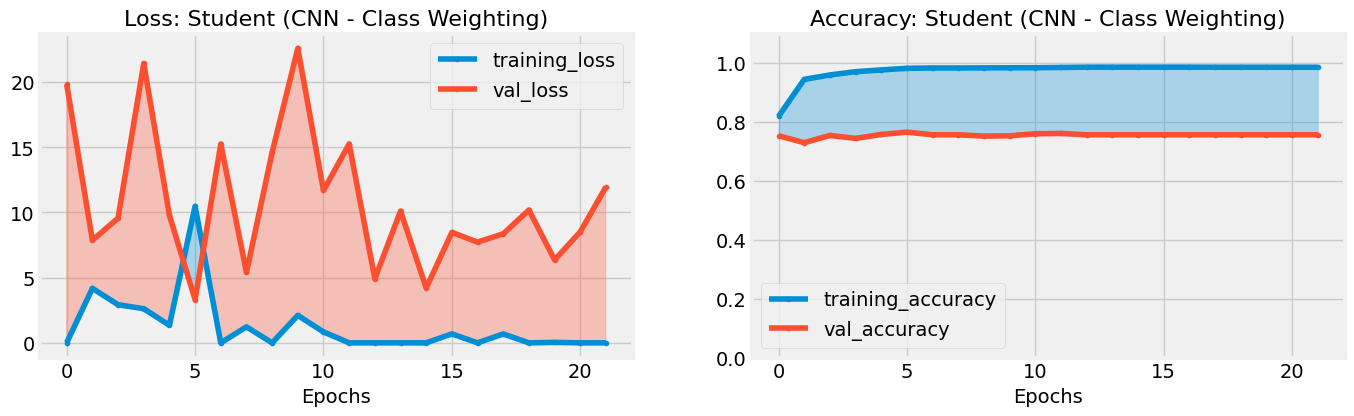

In [ ]:
plot_training_curves(history, 'Student (CNN - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (Multi-head Self-Attention)



In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256
# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
#vanilla=True ====> traditional transformer with multi-head self attention
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=True)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=True)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 49s 348ms/step - loss: 16.8405 - accuracy: 0.0586 - top5-acc: 0.2224 - Brier score: 537.7366 - auc: 0.5987 - val_loss: 3.7127 - val_accuracy: 0.0782 - val_top5-acc: 0.2972 - val_Brier score: 0.0288 - val_auc: 0.6841 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 37s 333ms/step - loss: 3.6700 - accuracy: 0.0826 - top5-acc: 0.3092 - Brier score: 0.1286 - auc: 0.6861 - val_loss: 3.5876 - val_accuracy: 0.0782 - val_top5-acc: 0.3084 - val_Brier score: 0.1183 - val_auc: 0.7014 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 37s 333ms/step - loss: 3.5484 - accuracy: 0.0834 - top5-acc: 0.3098 - Brier score: 0.2291 - auc: 0.6887 - val_loss: 3.5088 - val_accuracy: 0.0782 - val_top5-acc: 0.3084 - val_Brier score: 0.3551 - val_auc: 0.6857 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 37s 333ms/step - loss: 3.4998 - accuracy: 0.0834 - top5-acc: 0.3090 - Brier score: 0.4838 - auc: 0.

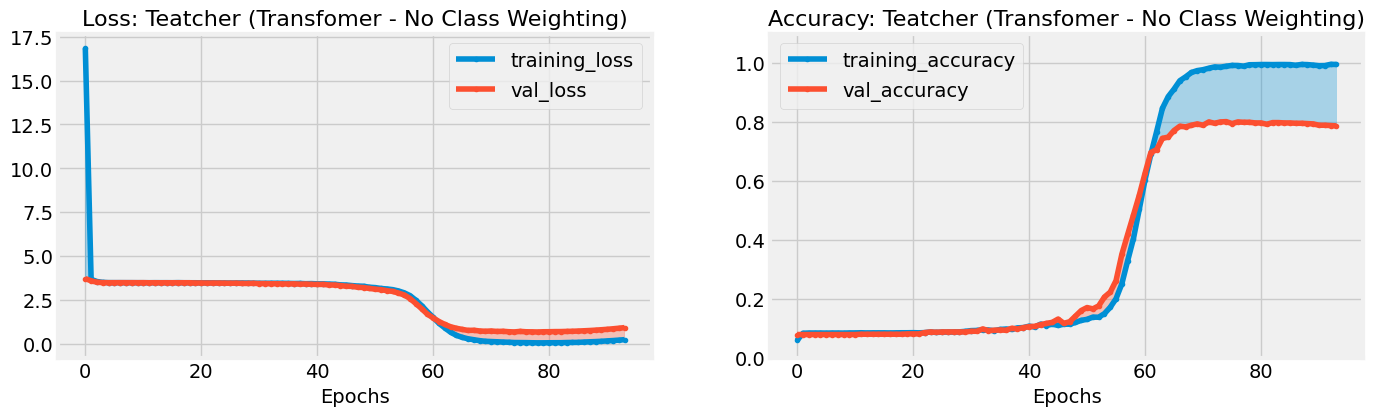

In [ ]:
plot_training_curves(history, 'Teatcher (Transfomer - No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 40s 231ms/step - accuracy: 0.0530 - top5-acc: 0.2275 - Brier score: 97.9975 - auc: 0.5908 - student_loss: 8.2376 - distillation_loss: 30.4111 - val_accuracy: 0.0782 - val_top5-acc: 0.2950 - val_Brier score: 0.1082 - val_auc: 0.7017 - val_student_loss: 3.6251 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 23s 202ms/step - accuracy: 0.0748 - top5-acc: 0.2744 - Brier score: 0.2332 - auc: 0.6831 - student_loss: 3.6656 - distillation_loss: 7.1485 - val_accuracy: 0.0782 - val_top5-acc: 0.2603 - val_Brier score: 0.1471 - val_auc: 0.7060 - val_student_loss: 3.7914 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 23s 202ms/step - accuracy: 0.0834 - top5-acc: 0.2813 - Brier score: 0.3461 - auc: 0.6977 - student_loss: 3.5397 - distillation_loss: 6.8271 - val_accuracy: 0.0782 - val_top5-acc: 0.2603 - val_Brier score: 0.6422 - val_auc: 0.7063 - val_student_loss: 3.5057 - lr: 0.0010
Epoch 4/100
112/112 [==

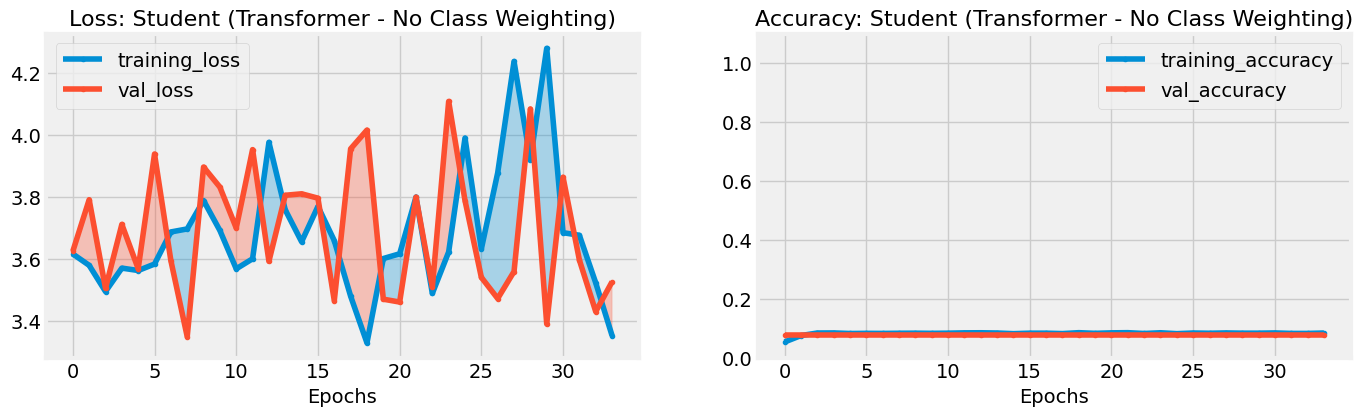

In [ ]:
plot_training_curves(history, 'Student (Transformer - No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 49s 349ms/step - loss: 4.0380 - accuracy: 0.0843 - top5-acc: 0.2850 - Brier score: 4.8104 - auc: 0.6071 - val_loss: 3.4942 - val_accuracy: 0.0916 - val_top5-acc: 0.4413 - val_Brier score: 0.1489 - val_auc: 0.7497 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 37s 330ms/step - loss: 3.7921 - accuracy: 0.0770 - top5-acc: 0.2995 - Brier score: 0.6851 - auc: 0.6482 - val_loss: 3.6296 - val_accuracy: 0.0860 - val_top5-acc: 0.3374 - val_Brier score: 0.0850 - val_auc: 0.6817 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 37s 330ms/step - loss: 3.7906 - accuracy: 0.0706 - top5-acc: 0.2760 - Brier score: 1.0943 - auc: 0.6401 - val_loss: 3.6674 - val_accuracy: 0.0804 - val_top5-acc: 0.3017 - val_Brier score: 0.0713 - val_auc: 0.6790 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 37s 330ms/step - loss: 3.7521 - accuracy: 0.0639 - top5-acc: 0.2797 - Brier score: 0.4747 - auc: 0.653

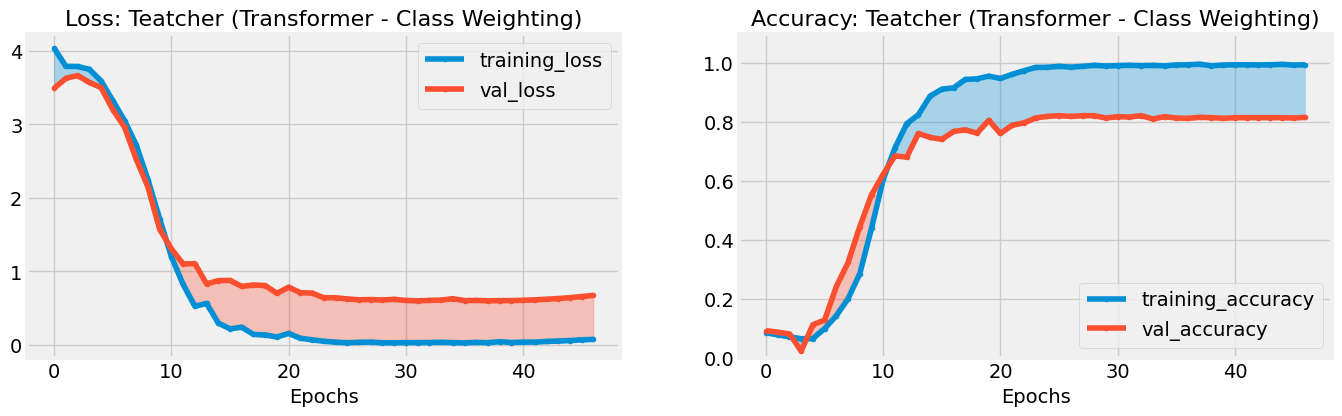

In [ ]:
plot_training_curves(history, 'Teatcher (Transformer - Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 39s 217ms/step - accuracy: 0.0809 - top5-acc: 0.2864 - Brier score: 1.9067 - auc: 0.6813 - student_loss: 3.6705 - distillation_loss: 13.3791 - val_accuracy: 0.0782 - val_top5-acc: 0.2883 - val_Brier score: 1.9639 - val_auc: 0.6720 - val_student_loss: 3.4849 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 23s 203ms/step - accuracy: 0.0829 - top5-acc: 0.2808 - Brier score: 1.8324 - auc: 0.6710 - student_loss: 3.6724 - distillation_loss: 13.3358 - val_accuracy: 0.0782 - val_top5-acc: 0.2726 - val_Brier score: 1.8607 - val_auc: 0.6716 - val_student_loss: 3.5826 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 22s 195ms/step - accuracy: 0.0832 - top5-acc: 0.2836 - Brier score: 1.8490 - auc: 0.6701 - student_loss: 3.6734 - distillation_loss: 13.3318 - val_accuracy: 0.0782 - val_top5-acc: 0.2883 - val_Brier score: 1.9175 - val_auc: 0.6720 - val_student_loss: 3.9072 - lr: 0.0010
Epoch 4/100
112/112 [=

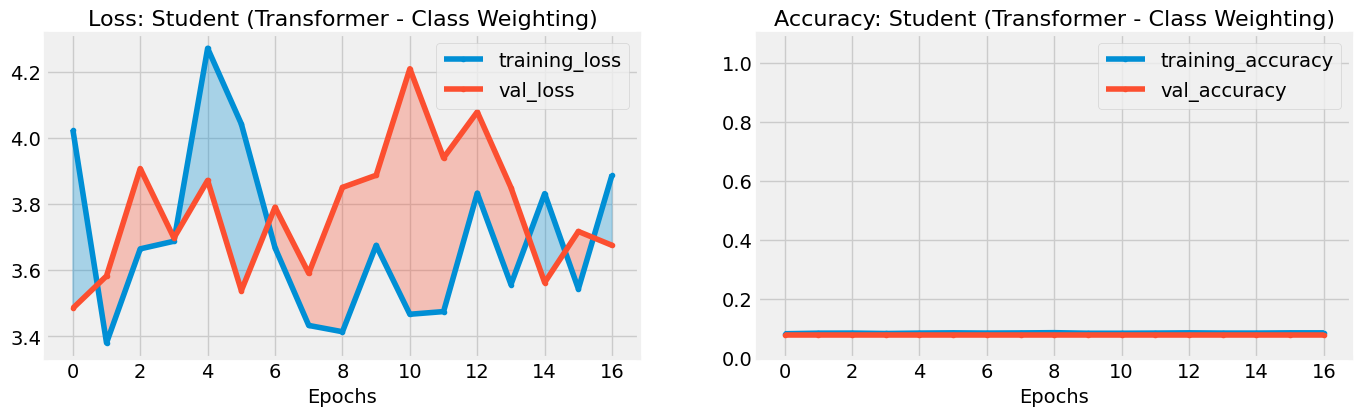

In [ ]:
plot_training_curves(history, 'Student (Transformer - Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (neighborhood attention)



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ Train the teacher, weighting = False





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = False)

Epoch 1/100
112/112 [==============================] - 54s 378ms/step - loss: 6.4082 - accuracy: 0.1993 - top5-acc: 0.4287 - Brier score: 25.4926 - auc: 0.6849 - val_loss: 2.4096 - val_accuracy: 0.4335 - val_top5-acc: 0.6536 - val_Brier score: 1.5220 - val_auc: 0.8314 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 40s 359ms/step - loss: 2.5778 - accuracy: 0.4114 - top5-acc: 0.6668 - Brier score: 14.6940 - auc: 0.7971 - val_loss: 1.9684 - val_accuracy: 0.5374 - val_top5-acc: 0.7307 - val_Brier score: 2.6598 - val_auc: 0.8598 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 40s 360ms/step - loss: 1.9798 - accuracy: 0.5484 - top5-acc: 0.7737 - Brier score: 22.3616 - auc: 0.8325 - val_loss: 1.6447 - val_accuracy: 0.5922 - val_top5-acc: 0.8112 - val_Brier score: 4.1708 - val_auc: 0.8816 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 40s 359ms/step - loss: 1.5214 - accuracy: 0.6430 - top5-acc: 0.8607 - Brier score: 30.6509 - auc: 0

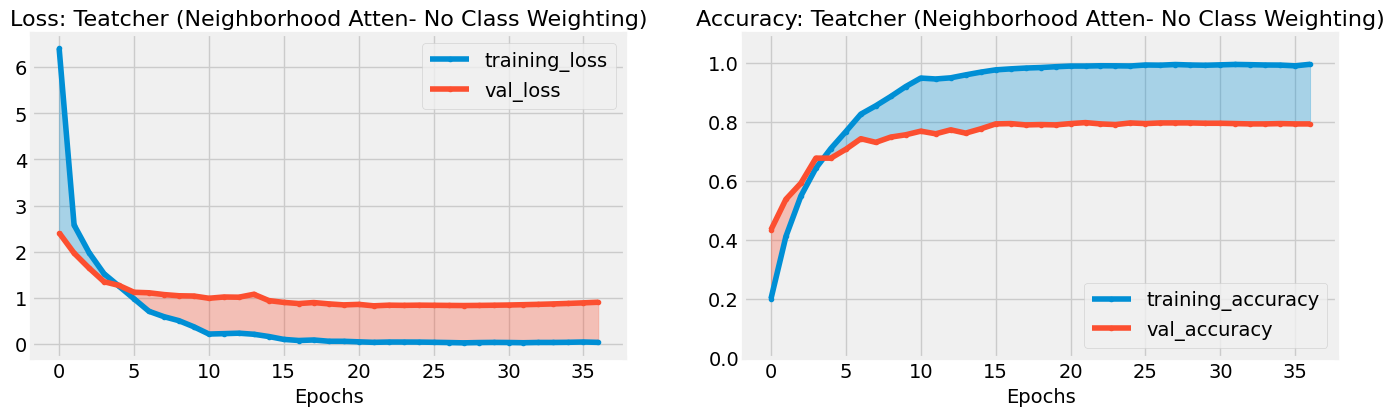

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- No Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = False


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = False)

Epoch 1/100
112/112 [==============================] - 43s 243ms/step - accuracy: 0.2132 - top5-acc: 0.4493 - Brier score: 17.8499 - auc: 0.7025 - student_loss: 5.0996 - distillation_loss: 24.9598 - val_accuracy: 0.4045 - val_top5-acc: 0.6715 - val_Brier score: 5.9710 - val_auc: 0.8275 - val_student_loss: 3.1481 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 26s 227ms/step - accuracy: 0.3651 - top5-acc: 0.6581 - Brier score: 19.8594 - auc: 0.7980 - student_loss: 2.9437 - distillation_loss: 18.4037 - val_accuracy: 0.4749 - val_top5-acc: 0.7453 - val_Brier score: 7.2948 - val_auc: 0.8536 - val_student_loss: 2.0702 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 25s 220ms/step - accuracy: 0.4242 - top5-acc: 0.7162 - Brier score: 20.9414 - auc: 0.8195 - student_loss: 2.6012 - distillation_loss: 16.9530 - val_accuracy: 0.4916 - val_top5-acc: 0.7698 - val_Brier score: 5.0000 - val_auc: 0.8710 - val_student_loss: 1.8686 - lr: 0.0010
Epoch 4/100
112/112

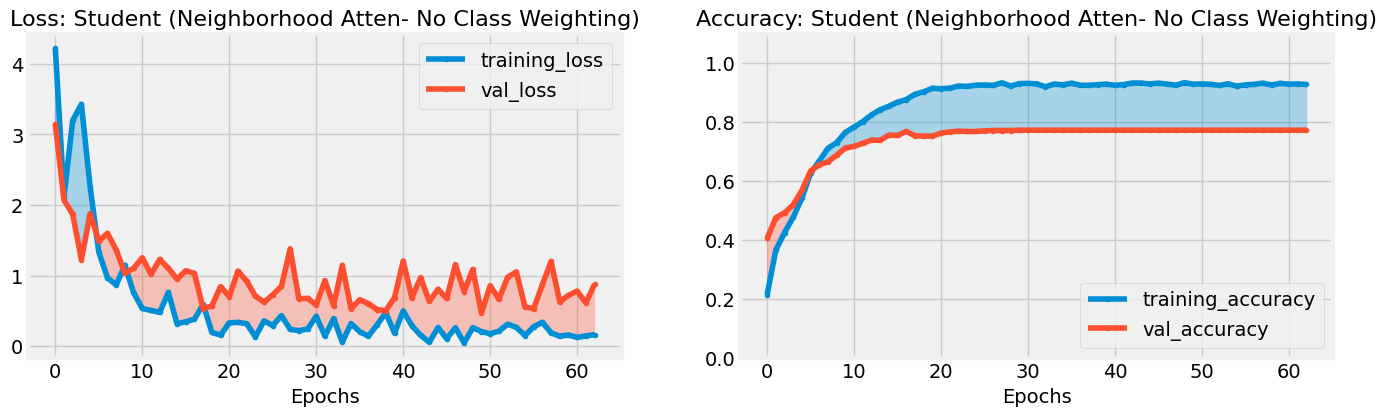

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- No Class Weighting)', model_name='student')

### ▶ Train the teacher, weighting = True





In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 311s 2s/step - loss: 8.6054 - accuracy: 0.0968 - top5-acc: 0.2509 - Brier score: 28.5313 - auc: 0.6030 - val_loss: 3.5919 - val_accuracy: 0.0883 - val_top5-acc: 0.2447 - val_Brier score: 0.3000 - val_auc: 0.5884 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 40s 357ms/step - loss: 3.9427 - accuracy: 0.1334 - top5-acc: 0.3288 - Brier score: 7.9411 - auc: 0.6509 - val_loss: 3.4671 - val_accuracy: 0.1251 - val_top5-acc: 0.3017 - val_Brier score: 0.6654 - val_auc: 0.6336 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 40s 358ms/step - loss: 3.4894 - accuracy: 0.1538 - top5-acc: 0.3265 - Brier score: 8.7999 - auc: 0.6574 - val_loss: 3.0780 - val_accuracy: 0.2268 - val_top5-acc: 0.4246 - val_Brier score: 2.7865 - val_auc: 0.7223 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 40s 357ms/step - loss: 3.1960 - accuracy: 0.1993 - top5-acc: 0.3944 - Brier score: 14.1498 - auc: 0.694

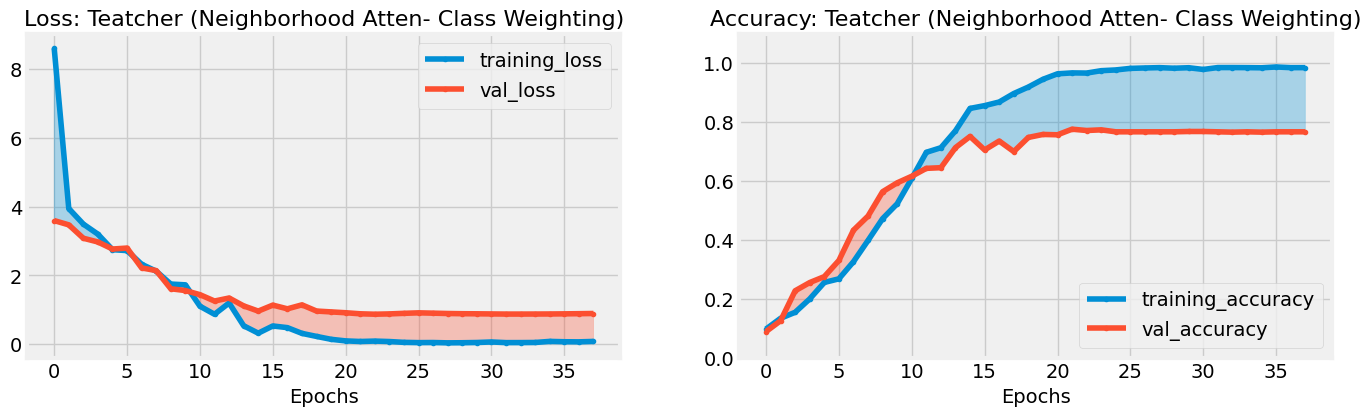

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- Class Weighting)', model_name='teacher')

### ▶ Distill teacher to student, weighting = True


In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 44s 243ms/step - accuracy: 0.1929 - top5-acc: 0.4348 - Brier score: 21.7845 - auc: 0.7054 - student_loss: 5.3081 - distillation_loss: 29.2800 - val_accuracy: 0.3777 - val_top5-acc: 0.6760 - val_Brier score: 7.7588 - val_auc: 0.8292 - val_student_loss: 3.4415 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 25s 220ms/step - accuracy: 0.3271 - top5-acc: 0.6151 - Brier score: 28.7502 - auc: 0.7934 - student_loss: 3.3551 - distillation_loss: 21.6260 - val_accuracy: 0.3899 - val_top5-acc: 0.6782 - val_Brier score: 5.2781 - val_auc: 0.8302 - val_student_loss: 2.1733 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 26s 227ms/step - accuracy: 0.3695 - top5-acc: 0.6673 - Brier score: 34.3665 - auc: 0.8180 - student_loss: 2.8840 - distillation_loss: 19.1001 - val_accuracy: 0.4704 - val_top5-acc: 0.7721 - val_Brier score: 8.4199 - val_auc: 0.8715 - val_student_loss: 2.1964 - lr: 0.0010
Epoch 4/100
112/112

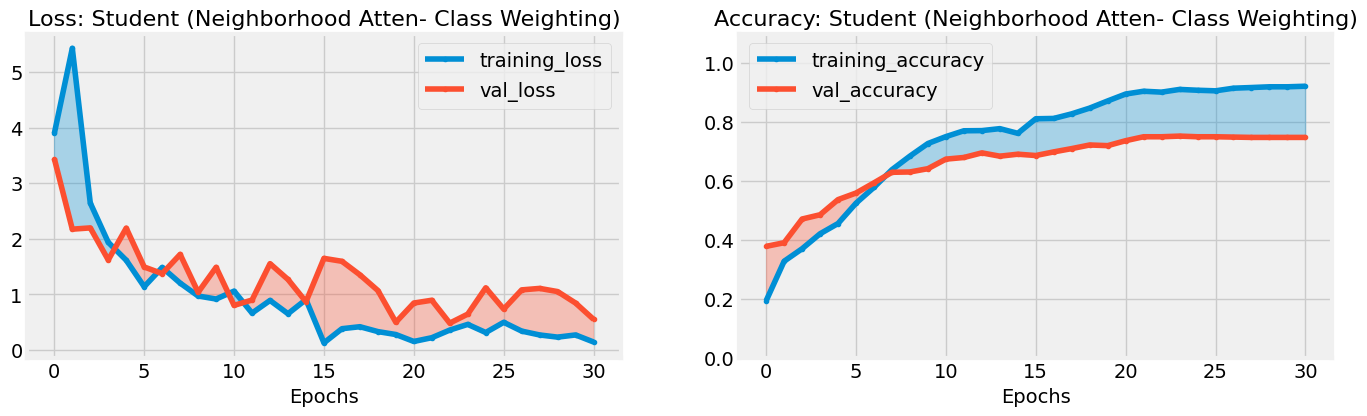

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- Class Weighting)', model_name='student')

In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher', weighting = True)

Epoch 1/100
112/112 [==============================] - 302s 2s/step - loss: 8.8173 - accuracy: 0.0882 - top5-acc: 0.2445 - Brier score: 29.2192 - auc: 0.6035 - val_loss: 3.3570 - val_accuracy: 0.1899 - val_top5-acc: 0.4067 - val_Brier score: 1.0563 - val_auc: 0.7025 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 40s 357ms/step - loss: 3.8961 - accuracy: 0.1432 - top5-acc: 0.3302 - Brier score: 8.7898 - auc: 0.6601 - val_loss: 3.2513 - val_accuracy: 0.2034 - val_top5-acc: 0.3620 - val_Brier score: 1.1114 - val_auc: 0.6834 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 40s 358ms/step - loss: 3.4815 - accuracy: 0.1672 - top5-acc: 0.3623 - Brier score: 10.3506 - auc: 0.6726 - val_loss: 3.0177 - val_accuracy: 0.2626 - val_top5-acc: 0.4536 - val_Brier score: 1.6078 - val_auc: 0.7355 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 40s 358ms/step - loss: 3.1760 - accuracy: 0.2118 - top5-acc: 0.4287 - Brier score: 12.6380 - auc: 0.70

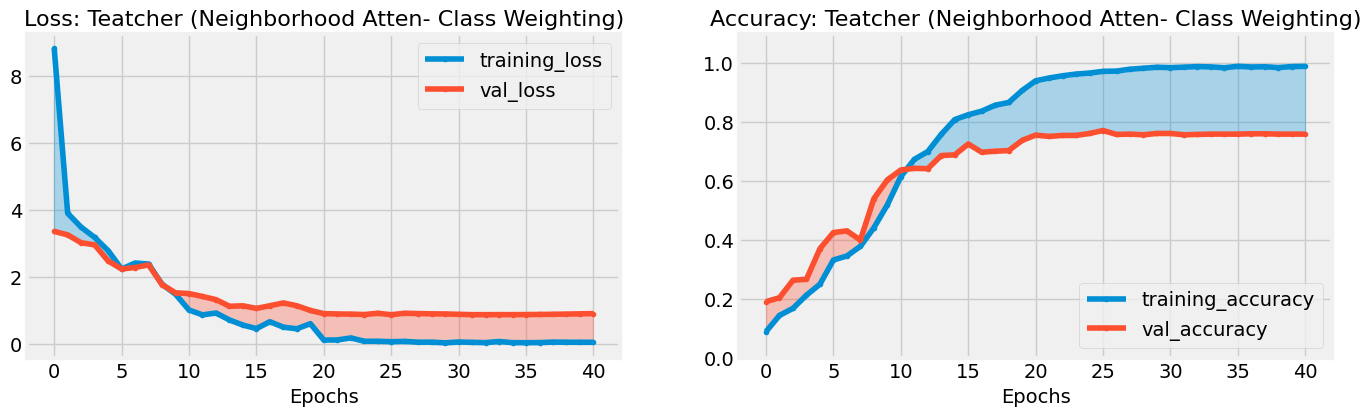

In [ ]:
plot_training_curves(history, 'Teatcher (Neighborhood Atten- Class Weighting)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller', weighting = True)

Epoch 1/100
112/112 [==============================] - 46s 245ms/step - accuracy: 0.1870 - top5-acc: 0.4253 - Brier score: 21.9101 - auc: 0.6991 - student_loss: 5.5246 - distillation_loss: 30.3791 - val_accuracy: 0.3575 - val_top5-acc: 0.6358 - val_Brier score: 5.0801 - val_auc: 0.8255 - val_student_loss: 2.2671 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 25s 221ms/step - accuracy: 0.3279 - top5-acc: 0.6235 - Brier score: 32.1732 - auc: 0.7949 - student_loss: 3.4392 - distillation_loss: 21.3745 - val_accuracy: 0.4581 - val_top5-acc: 0.7173 - val_Brier score: 9.8920 - val_auc: 0.8536 - val_student_loss: 3.6250 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 26s 228ms/step - accuracy: 0.3815 - top5-acc: 0.6924 - Brier score: 37.3094 - auc: 0.8192 - student_loss: 2.8995 - distillation_loss: 18.5965 - val_accuracy: 0.4458 - val_top5-acc: 0.7430 - val_Brier score: 7.6988 - val_auc: 0.8696 - val_student_loss: 2.0376 - lr: 0.0010
Epoch 4/100
112/112

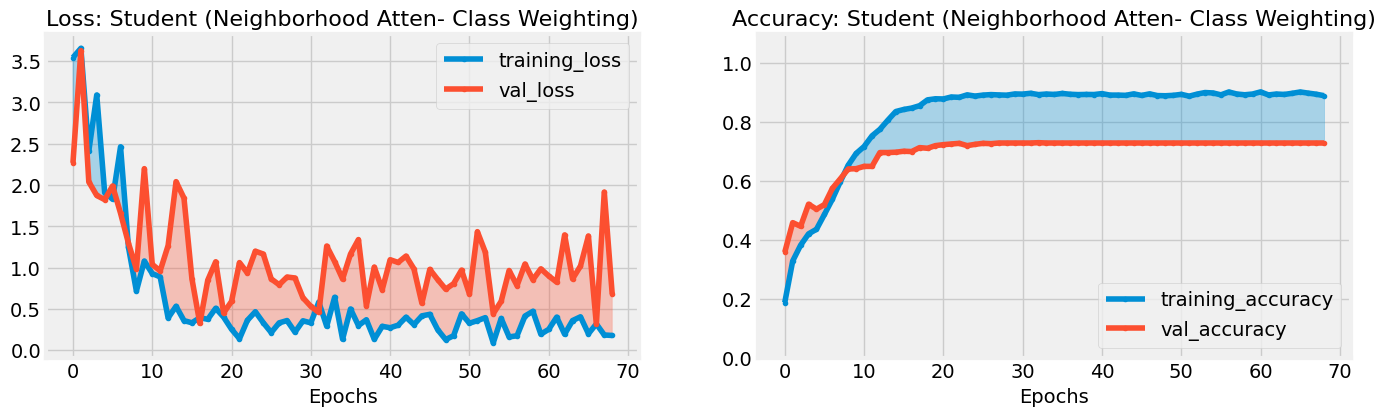

In [ ]:
plot_training_curves(history, 'Student (Neighborhood Atten- Class Weighting)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del transformer_teacher
del transformer_student